# **Diplomado IA: Relacional, GANs, RL, Meta-Learning, Razonamiento y Memoria**. <br> Práctico 27: Redes Neuronales de Grafos

---
---

**Profesor:**
- Carlos Aspillaga

**Ayudante:**
- Roshad Alipanah
---
---

# **Instrucciones Generales**

El siguiente práctico se debe realizar **individualmente**. El formato de entrega es el **archivo .ipynb con todas las celdas ejecutadas**. Todas las preguntas deben ser respondidas en las celdas dispuestas para ello. No se aceptará el _output_ de una celda de código como respuesta.

**Nombre alumno:** COMPLETAR

El siguiente práctico cuenta con varias secciones y en varias de ellas se incluye actividades a realizar.

**IMPORTANTE: habrá un bonus de 1 décima para todos aquellos alumnos/as que muestren buen orden en sus respuestas (esto aplica a legibilidad de código, buena redacción, formalidad, organización del jupyter notebook, seguimiento de instrucciones, etc). El criterio lo pondrá cada ayudante corrector. La nota máxima obtenible en el laboratorio es 7.0**

# **Índice**

>[Diplomado IA: Relacional, GANs, RL, Meta-Learning, Razonamiento y Memoria.  Práctico 2: Redes Neuronales de Grafos](#scrollTo=tHopPtVaNF1K)

>[Instrucciones Generales](#scrollTo=D4--58EgLXxI)

>[Índice](#scrollTo=jCb8075QLdVx)

>[Instalación de dependencias](#scrollTo=SAnmbCervFZu)

>[Explorando Grafos con Pytorch Geometric](#scrollTo=-YWyqn8m9ry5)

>[Usando Redes Neuronales de Grafos](#scrollTo=mgFjMn7oZ9Hi)

>>[Ejemplo básico de clasificación de nodos](#scrollTo=fqIkU298tdNS)

>>[Ejemplo más avanzado de clasificación de nodos](#scrollTo=1Z6Xyzcpb_w7)

>>[Ejemplo de clasificación de Grafos](#scrollTo=pDH-fHUxdrKM)

>>[(Material Opcional) Probando la técnica de Morris et al.](#scrollTo=Kn461H9sf1_3)

>[(Material Opcional) Trucos útiles](#scrollTo=lAgCLGJHhTf_)

>>[¿Qué hago si mi grafo es tan grande que no cabe en GPU?](#scrollTo=OvsAPj6ehWhp)

>>[¿Cómo creo Grafos y Dataloaders con mis propios datos?](#scrollTo=9ubdnQ3bn1vA)

>>[¿Cómo lo hago si quiero explorar arquitecturas de GNN más "a la medida" o usar otros modelos?](#scrollTo=P91qDMRDAvD6)

>[Actividades](#scrollTo=IsgDLMyaomU1)

>>[Actividad 1:](#scrollTo=JwVgRyUWpJ2V)

>>[Actividad 2:](#scrollTo=B0NYTTAuvBwu)

>>[Actividad 3:](#scrollTo=Tbu3wXevwLf9)

>>[Actividad 4:](#scrollTo=6bApLBCuz8Ij)



**Créditos**: Parcialmente basado en ejemplos de https://pytorch-geometric.readthedocs.io/


# **Instalación de dependencias**

Primero revisamos la version de torch, para luego decidir la version correcta de pytorch geometric

In [1]:
from torch import __version__
__version__

'2.1.0+cu118'

Dado lo anterior, instalamos las versiones compatibles de scatter y sparse

In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-2.0.1+cu118.html
!pip install -q torch-geometric
!pip3 install networkx==2.5.1
!pip3 install python-louvain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


# **Explorando Grafos con Pytorch Geometric**

En esta primera actividad, exploraremos un dataset tradicional de grafos llamado "Karate Club Network", propuesto por Wayne W. Zachary en su paper “An Information Flow Model for Conflict and Fission in Small Groups”, en 1977

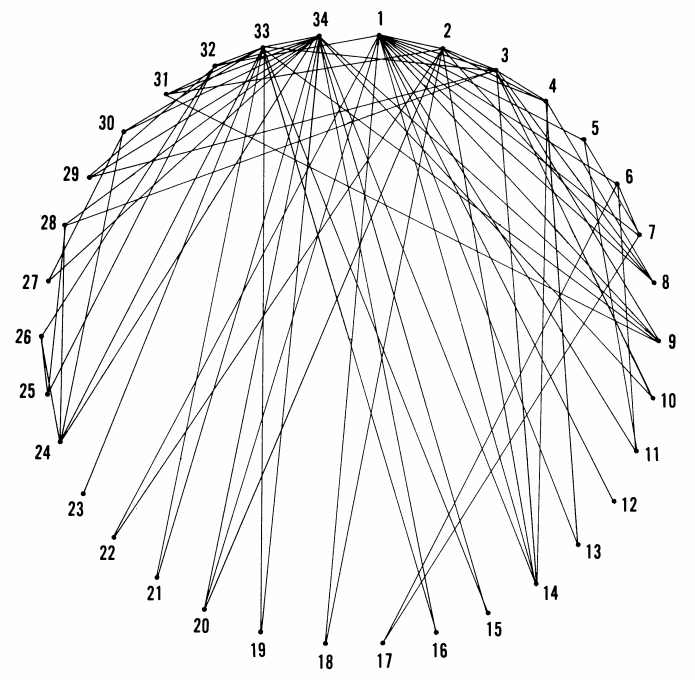

In [3]:
!if [ ! -f karate_club.png ]; then wget -q https://www.dropbox.com/s/inmyr76hbhrgb5h/karate_club.png; fi
import IPython
import pylab
%matplotlib inline
pil_img = IPython.display.Image(filename='karate_club.png', width=450, height=450)
IPython.display.display(pil_img)

>"*A line is drawn between two points when the two individuals being represented consistently interacted in contexts outside those of karate classes, workouts, and club meetings.*"
>>**Fuente**: *paper original "An Information Flow Model for Conflict and Fission in Small Groups"*

El dataset contiene grafos almacendados en objetos de tipo `Data`. Estas clases de Pytorch Geometric tienen atributos que permiten revisar sus estadísticas

In [4]:
from torch_geometric.datasets import KarateClub

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN5torch8autograd13_wrap_outputsERKSt6vectorIN2at6TensorESaIS3_EERKSt13unordered_setIPN3c1010TensorImplESt4hashISB_ESt8equal_toISB_ESaISB_EESJ_NS9_8ArrayRefINS9_8optionalIS3_EEEERKSt10shared_ptrINS0_4NodeEESt8functionIFS5_S5_S5_EE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd13_wrap_outputsERKSt6vectorIN2at6TensorESaIS3_EERKSt13unordered_setIPN3c1010TensorImplESt4hashISB_ESt8equal_toISB_ESaISB_EESJ_NS9_8ArrayRefINS9_8optionalIS3_EEEERKSt10sh

In [5]:
dataset = KarateClub()
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Obtener el primer (y único) grafo como objeto de clase Data
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 34
Number of classes: 4
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Mediante el atributo `edge_index` podemos explorar las aristas del grafo. Aqui observamos las aristas desde el indice 10 al 29

In [6]:
edge_index = data.edge_index
print(edge_index.t()[10:30,:])

tensor([[ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8]])


Mediante el atributo `x` podemos explorar los features de los nodos. En este caso son simplemente vectores de tipo "one-hot", que no aportan informacion muy util del nodo

In [7]:
features = data.x
print(features.t()[:10,:10])

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


Mediante el atributo `y` podemos explorar los labels (clases)

In [8]:
classes = data.y
print(classes.t()[:10])

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1])


A continuación visualizaremos el Grafo

In [9]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.utils import to_networkx

def visualize(h, color, epoch=None, loss=None, tsne=False):
    plt.figure(figsize=(8,8))
    if not tsne:
        if torch.is_tensor(h):
            h = h.detach().cpu().numpy()
            plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
            if epoch is not None and loss is not None:
                plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
        else:
            nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                            node_color=color, cmap="Set2")
    else:
        z = TSNE(n_components=2, init='pca').fit_transform(out.detach().cpu().numpy())
        plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

G = to_networkx(data, to_undirected=True)
#visualize(G, color=data.y)

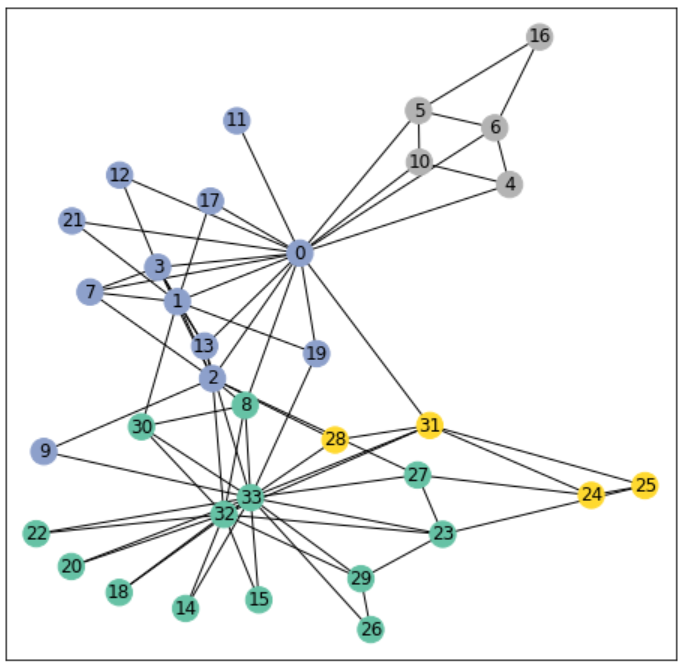

De la imagen anterior, vemos cierto ordenamiendo de los nodos. Esto proviene de la libreria que estamos usando, que busca la forma de mostrar el grafo tal que se visualice bien, pero en realidad no existe un ordenamiento predefinido para ubicar los nodos en la visualizacion.

# **Usando Redes Neuronales de Grafos**

## Ejemplo básico de clasificación de nodos

Para este ejemplo usaremos una capa de tipo **GCN**, propuesta por [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), que se define como

$$
\mathbf{h}_i^{(t + 1)} = \mathbf{W}^{(t + 1)} \sum_{j \in \mathcal{N}(i) \, \cup \, \{ i \}} \frac{1}{c_{i,j}} \cdot \mathbf{h}_j^{(t)}
$$

donde $\mathbf{W}^{(t + 1)}$ es una matriz entrenable de tamaño `[num_output_features, num_input_features]` y $c_{i,j}$ es un coeficiente fijo de normalización por cada arista.

Pytorch Geometric implementa esta capa mediante la clase [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) y el modo de uso es (casi) idéntico a como usamos las convoluciones de pytorch para imágenes.

In [10]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(1)
        # creamos nuestra GCN con 3 capas convolucionales
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        # finalmente nuestra capa de clasificación a num_clases
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        out = self.classifier(h)
        return out, h

Ahora podemos visualizar nuestra GCN antes de entrenar.
Es interesante ver que a pesar de tener pesos **completamente aleatorios** sin ningún tipo de entrenamiento, la forma en que se definen las convoluciones de grafos introduce un bias inductivo poderoso, generando embeddings que se asemejan a la estructura de comunidad del grafo al asignar embeddings similares a nodos cercanos en el grafo.

Embedding shape: [34, 2]


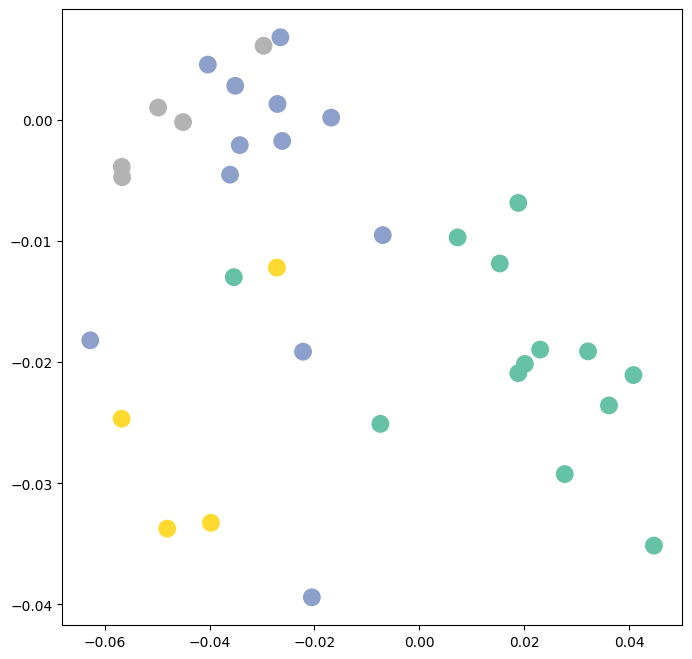

In [11]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

Ahora entrenemos nuestra **GCN** para ver si es capaz de generar una mejor separación de las clases

<IPython.core.display.Javascript object>

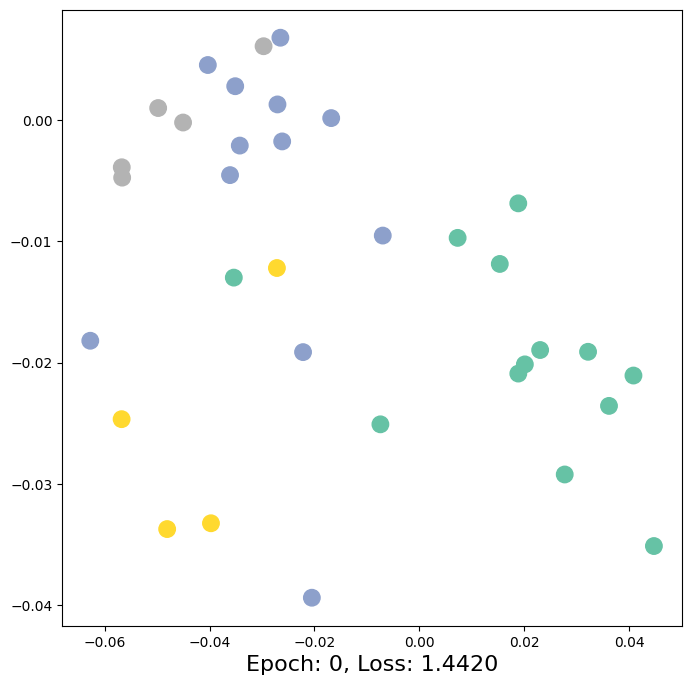

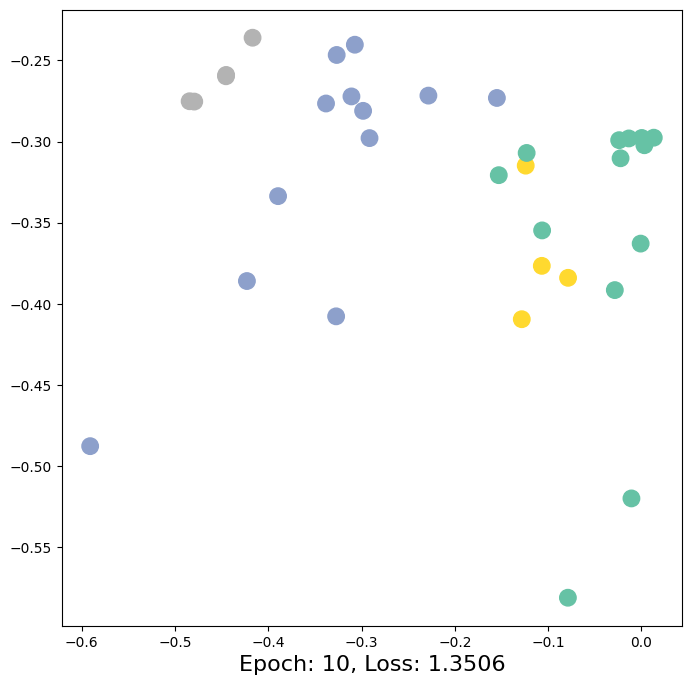

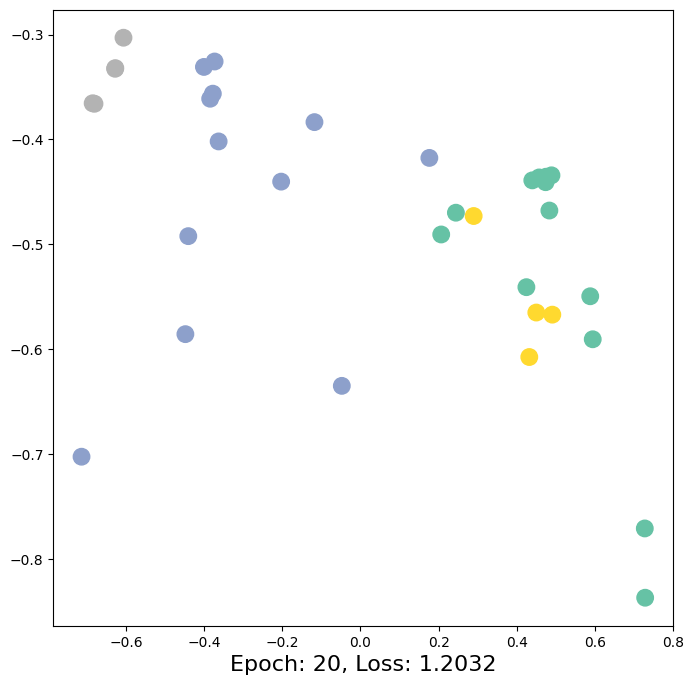

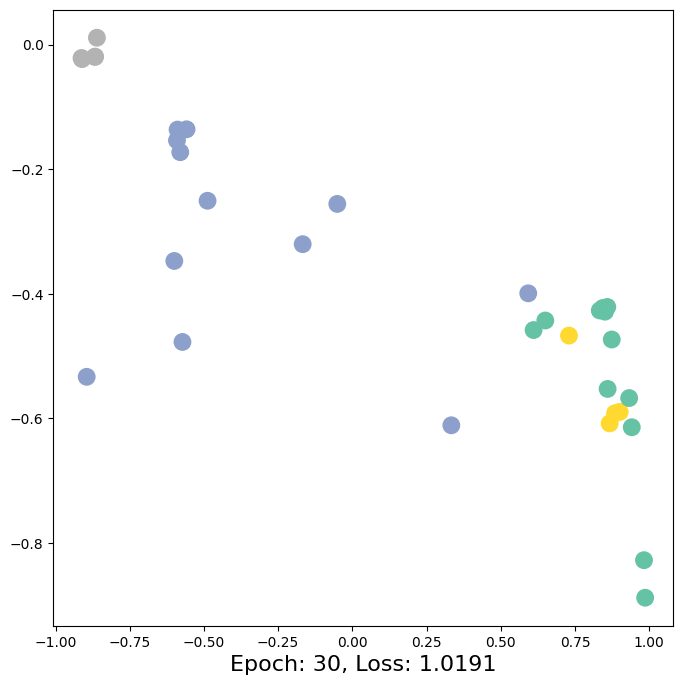

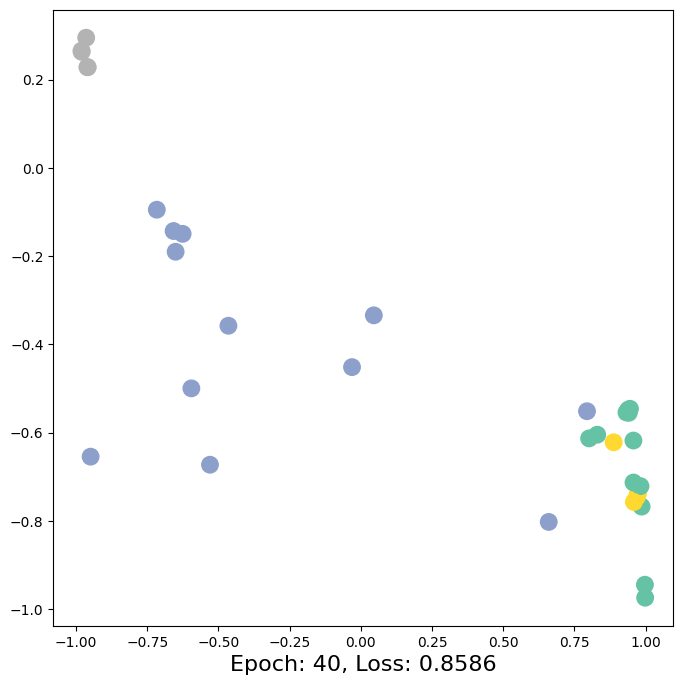

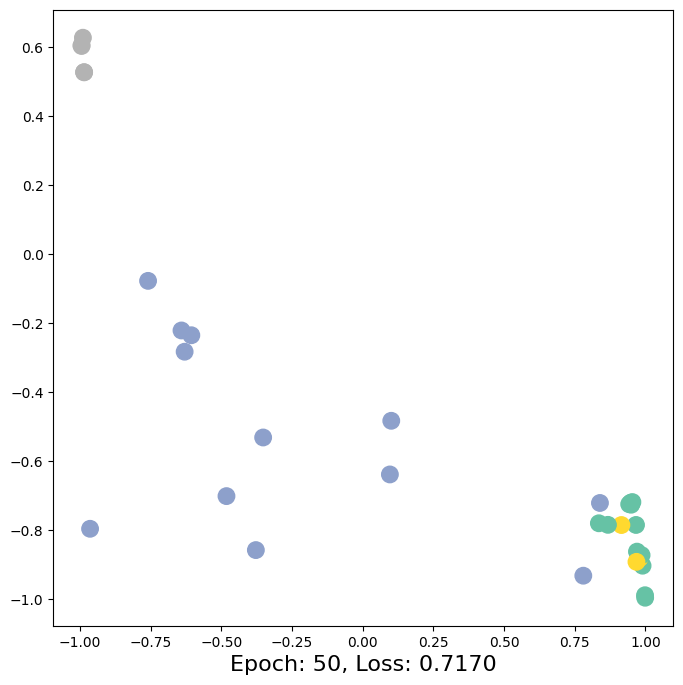

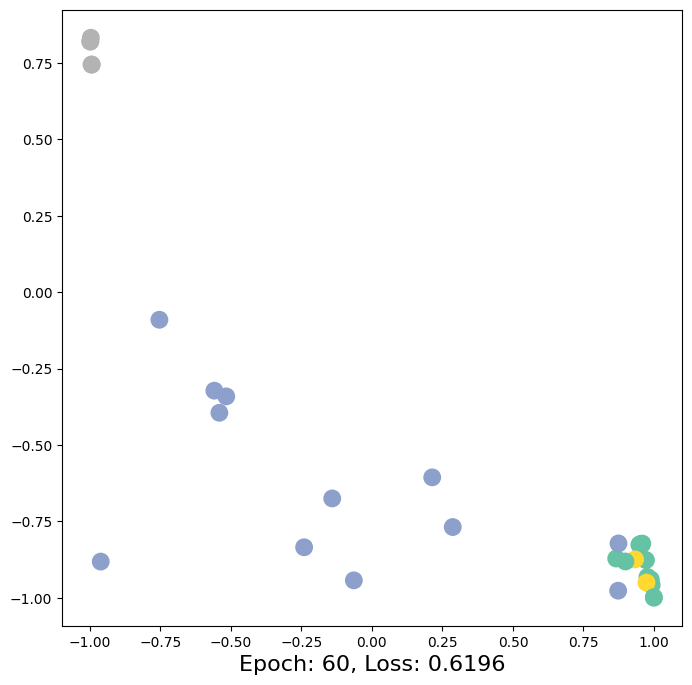

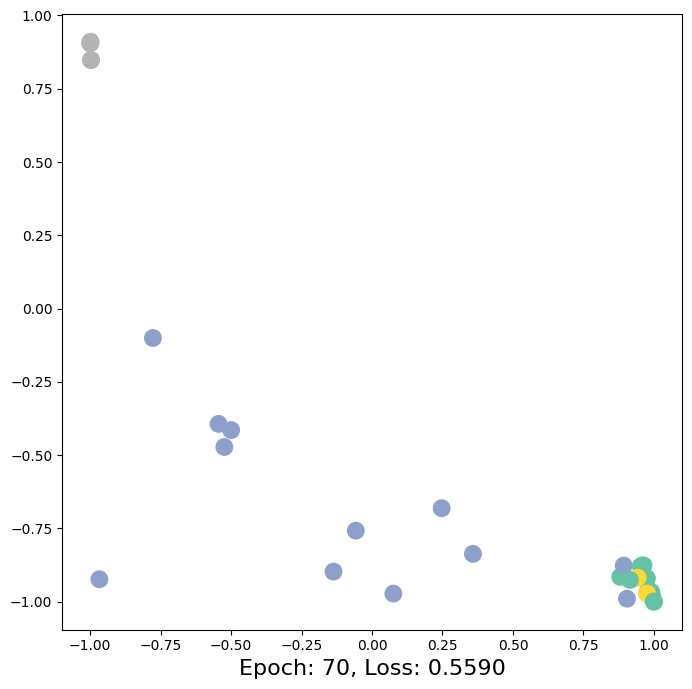

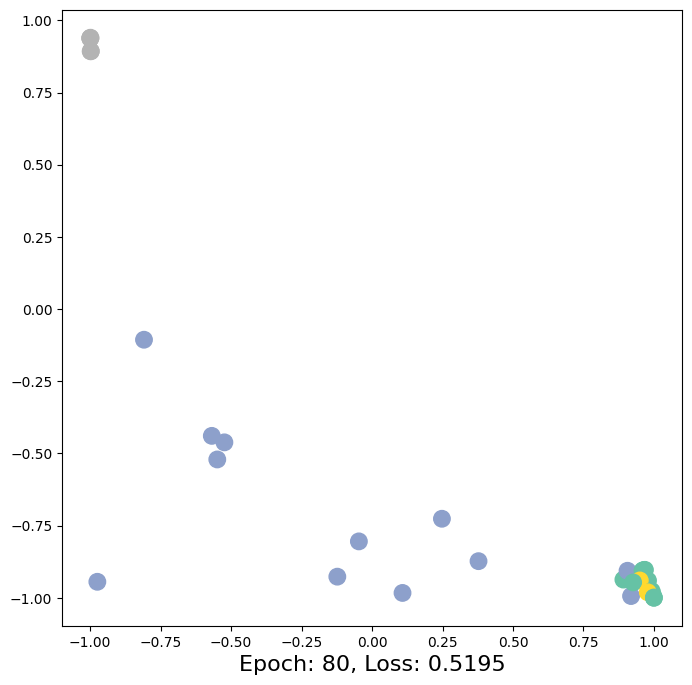

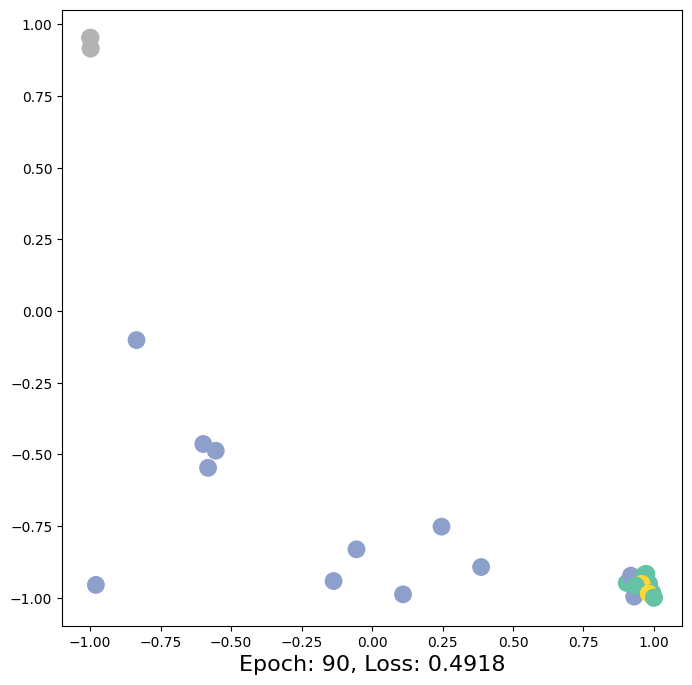

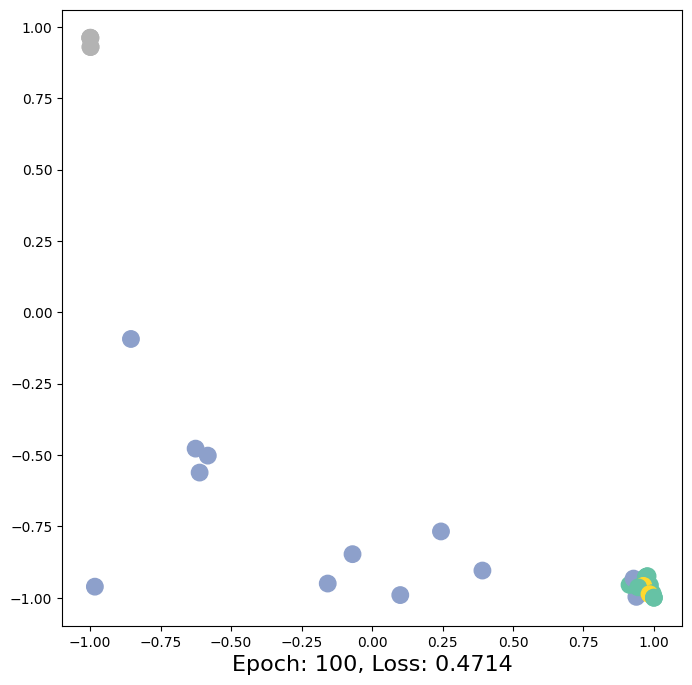

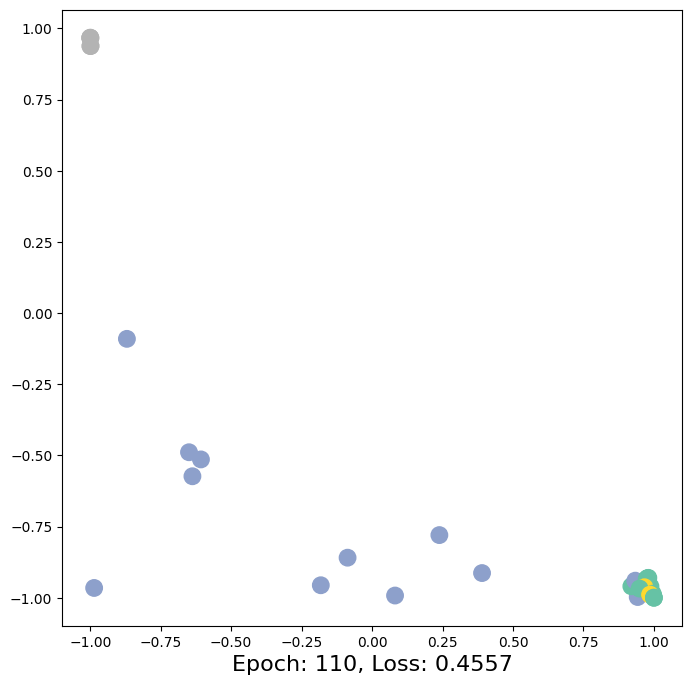

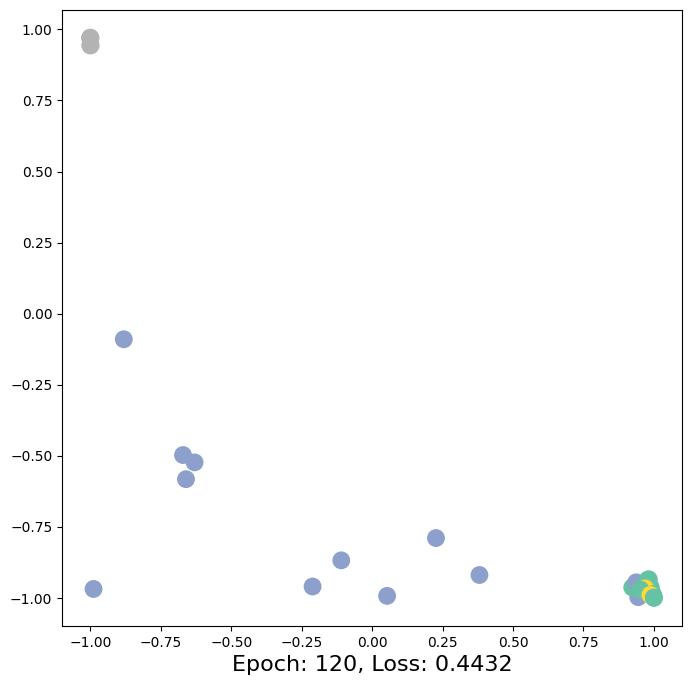

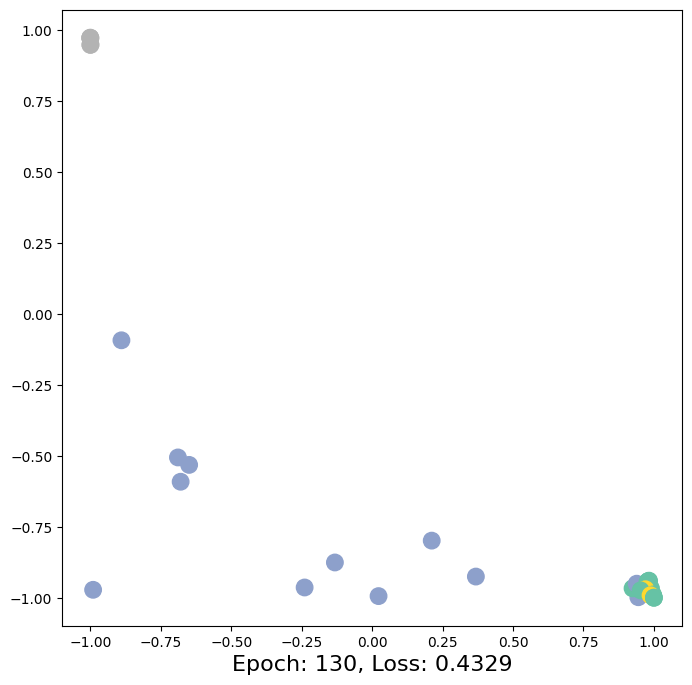

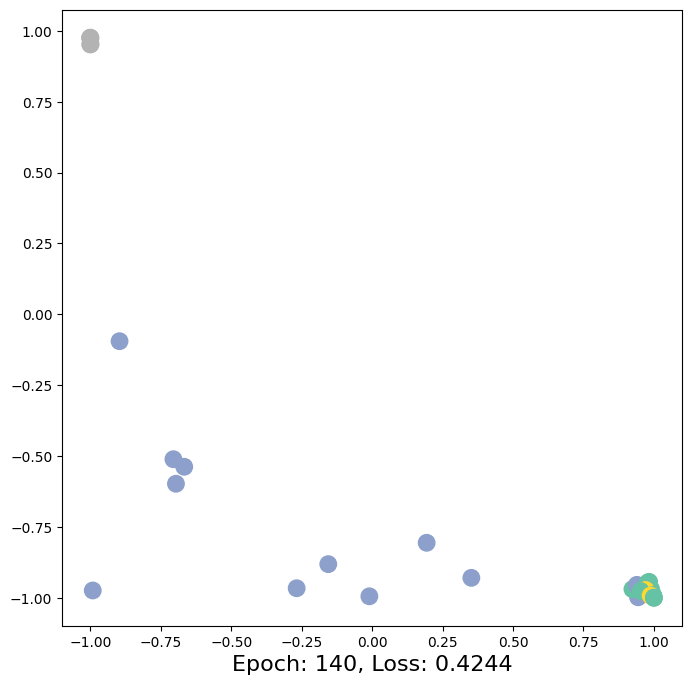

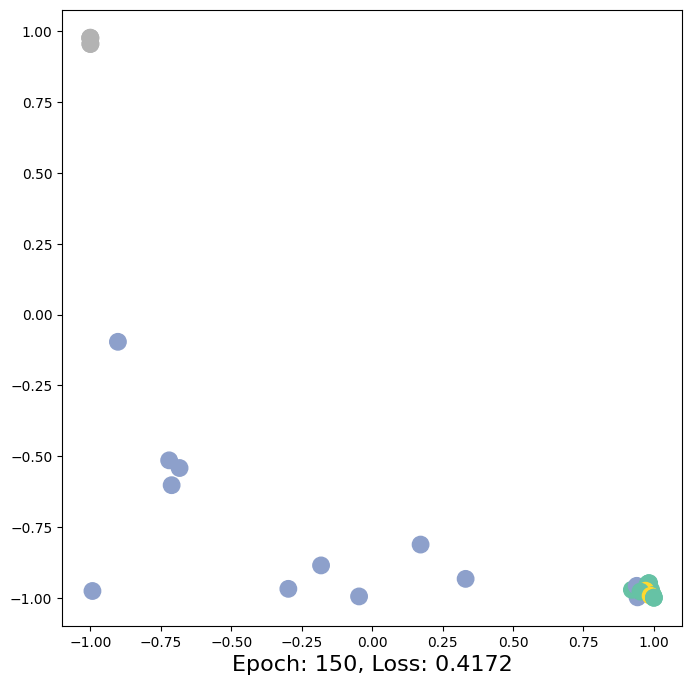

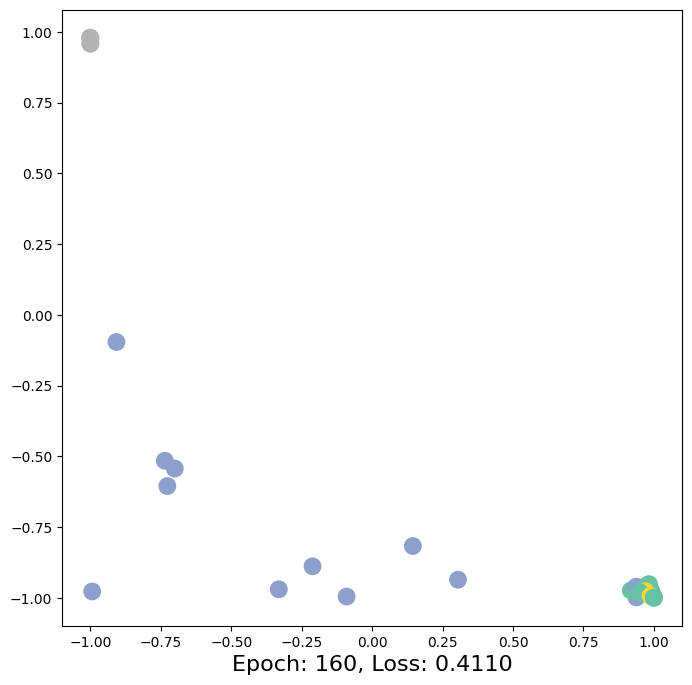

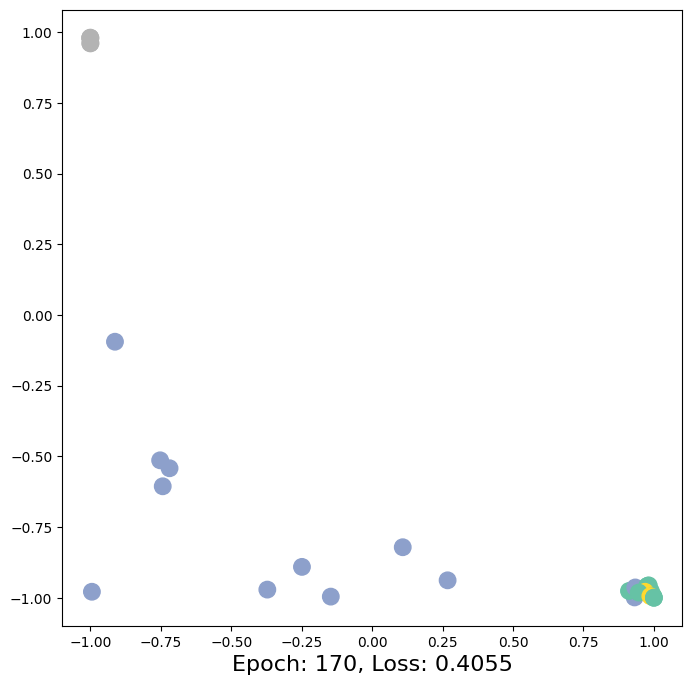

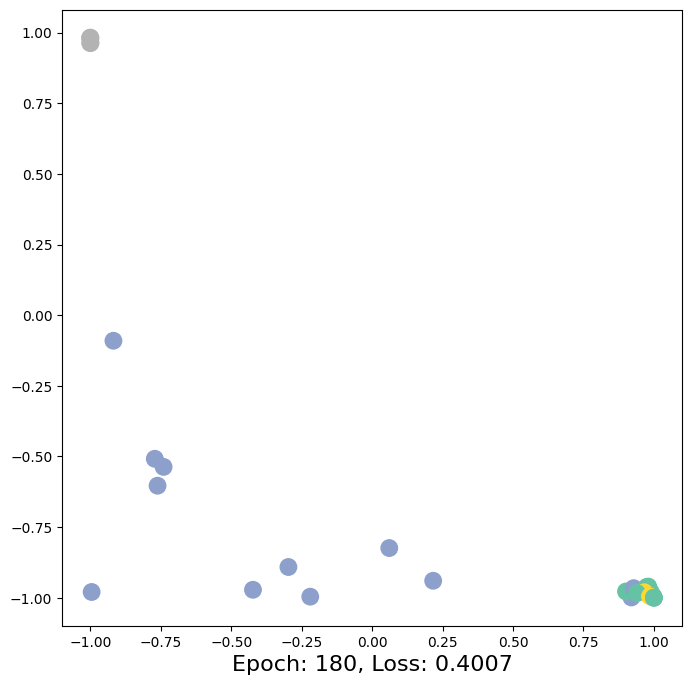

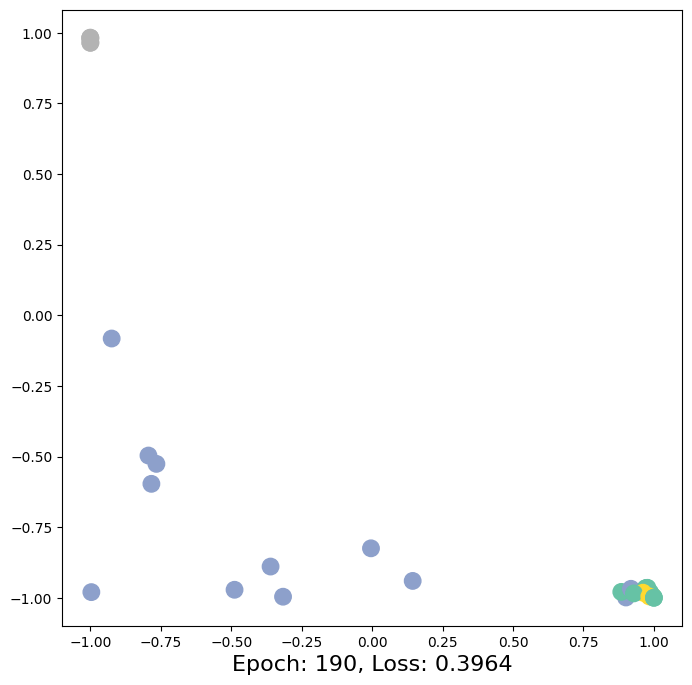

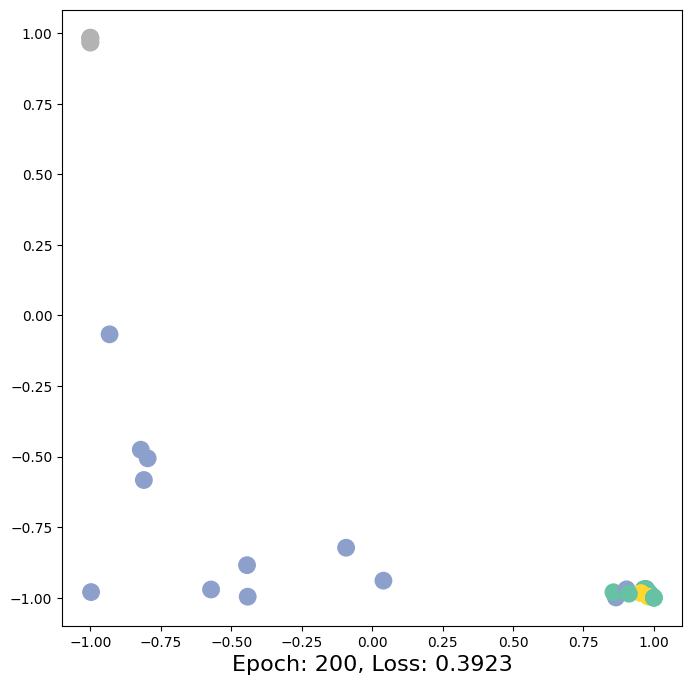

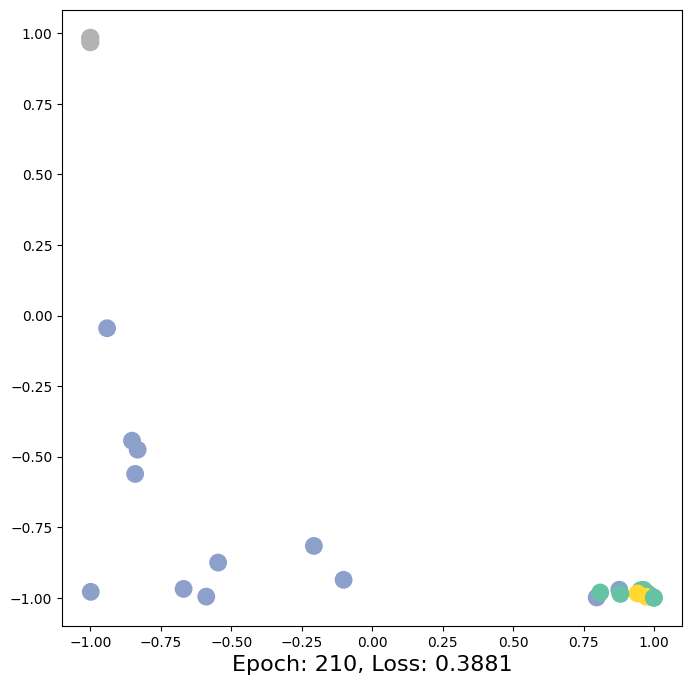

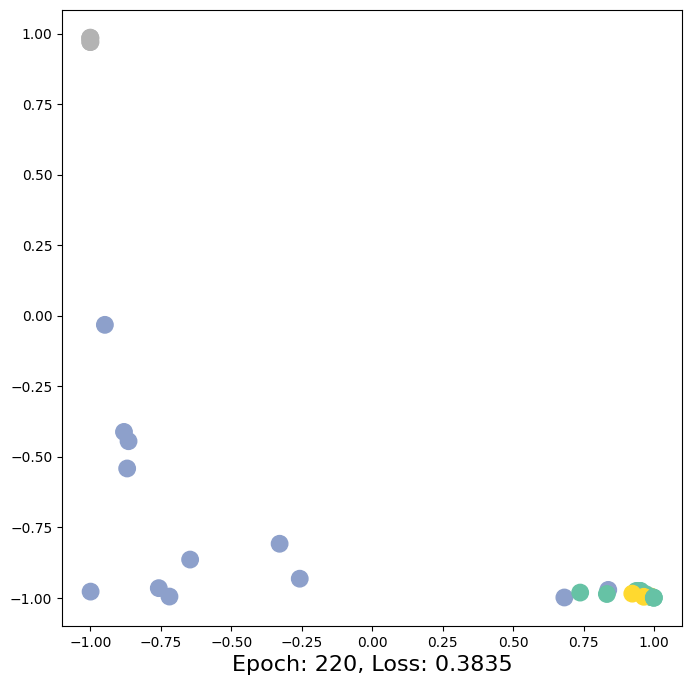

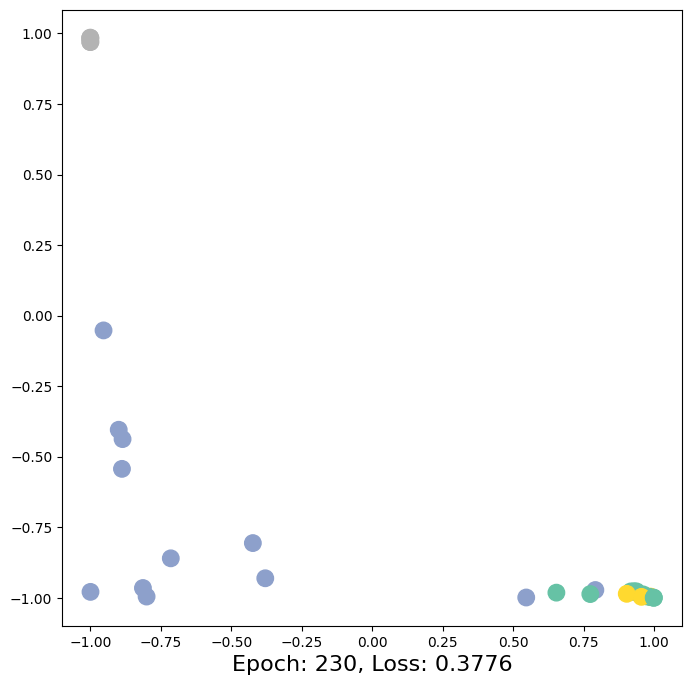

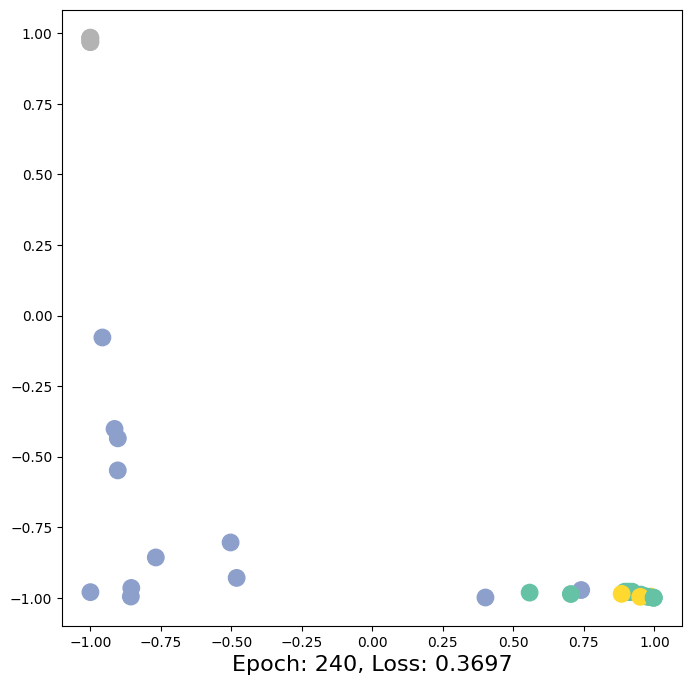

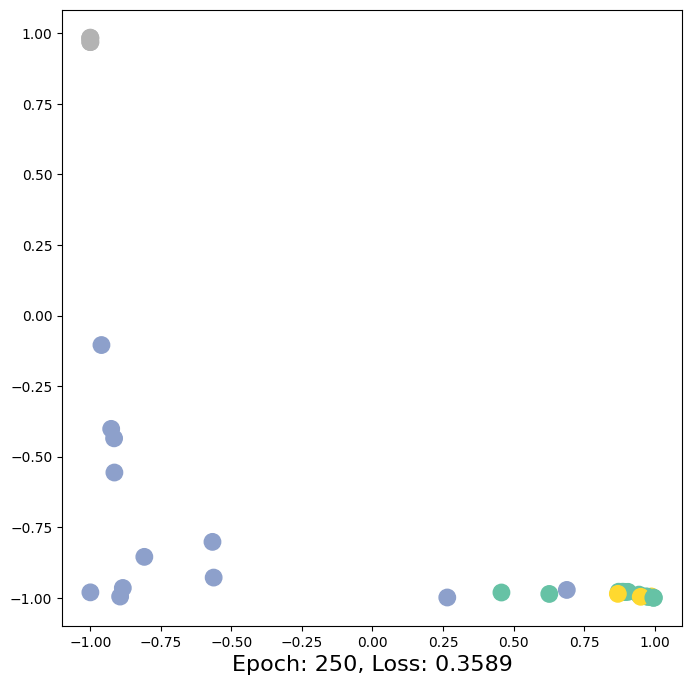

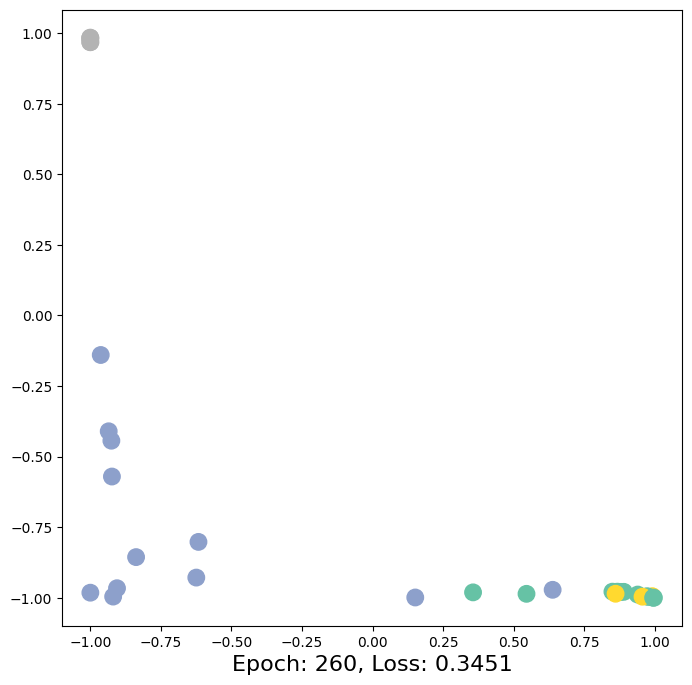

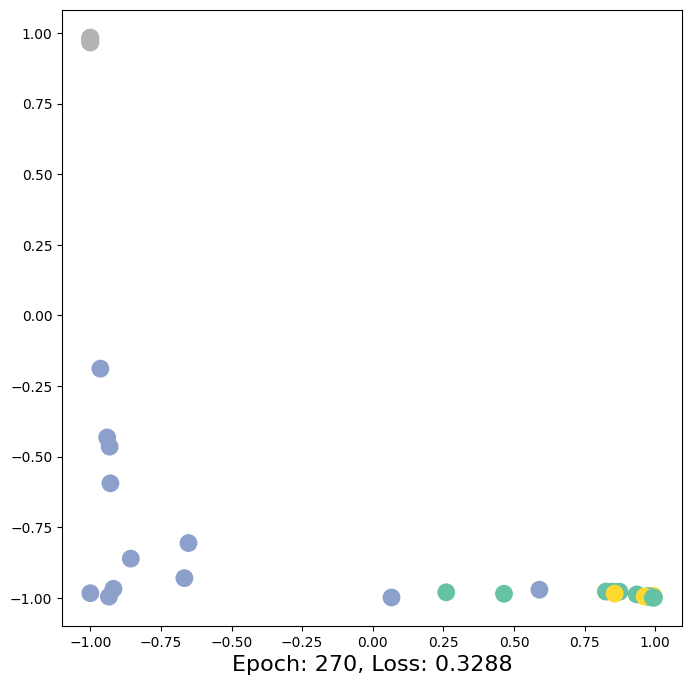

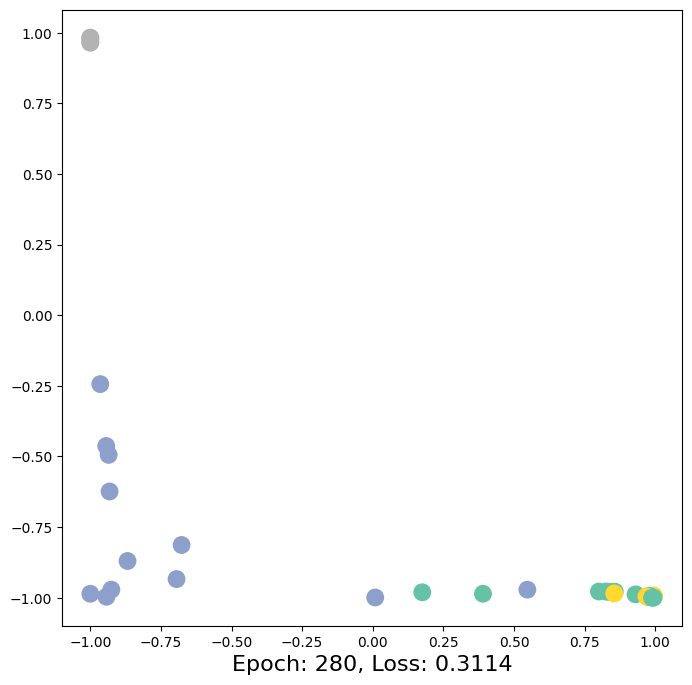

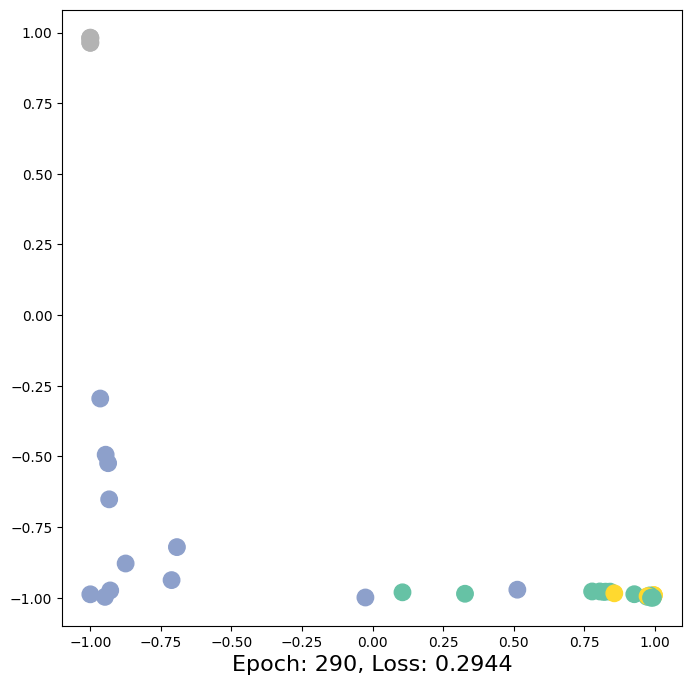

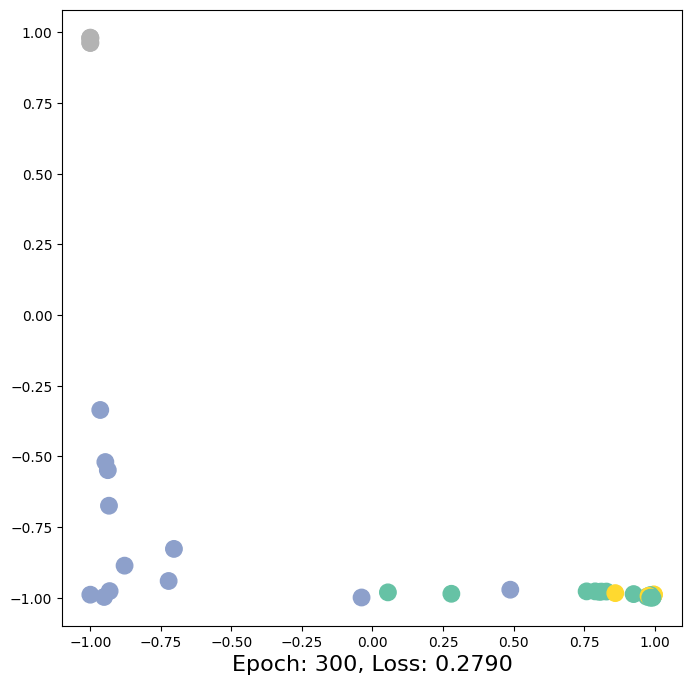

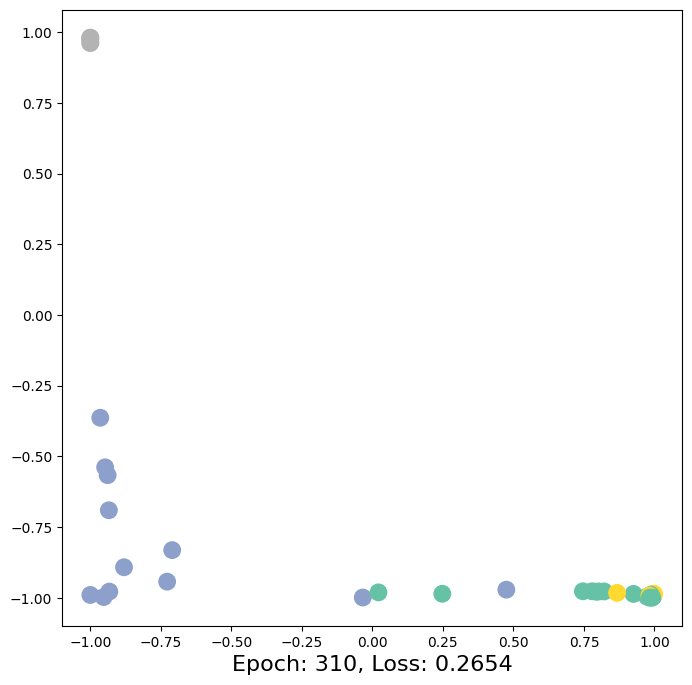

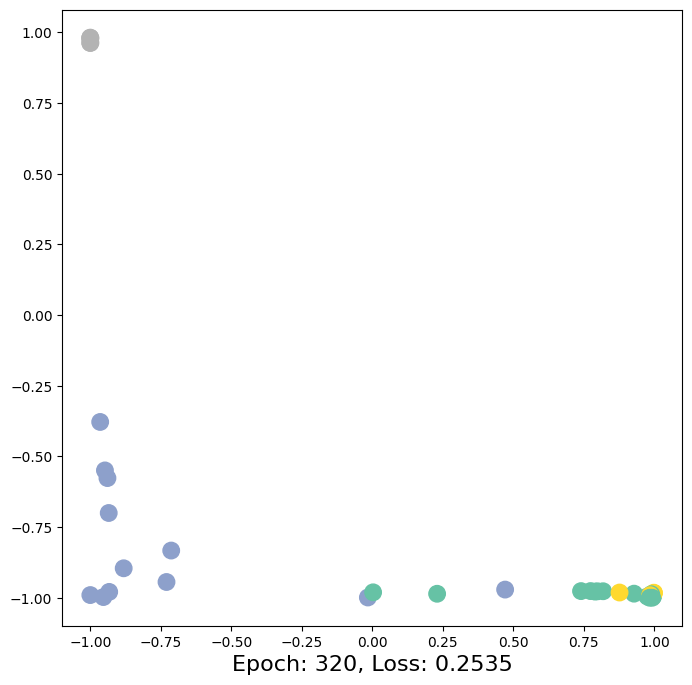

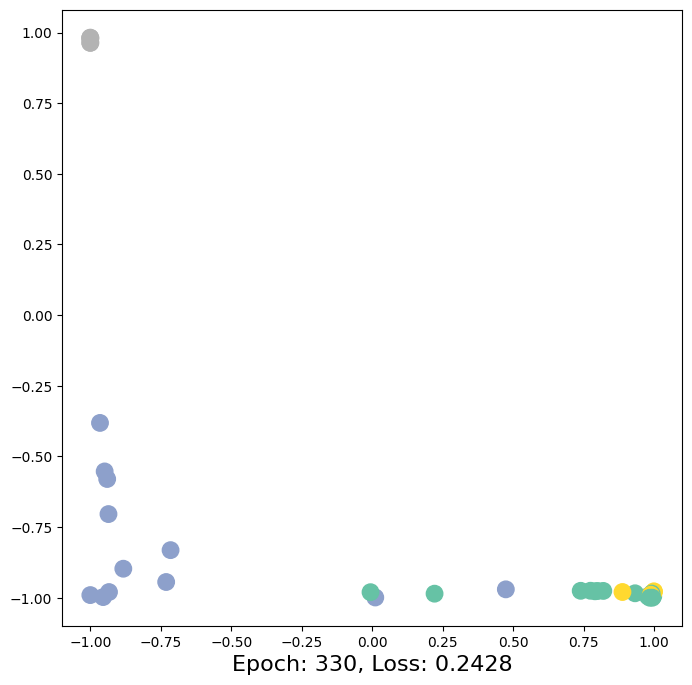

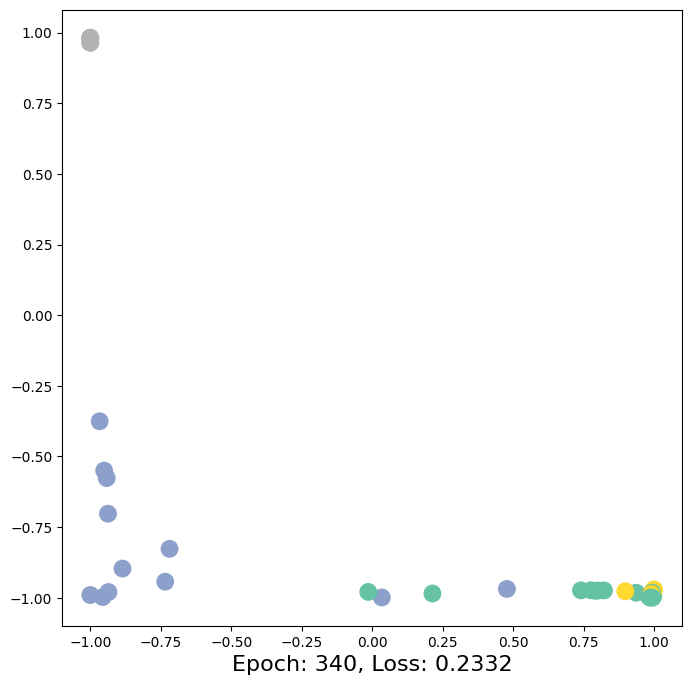

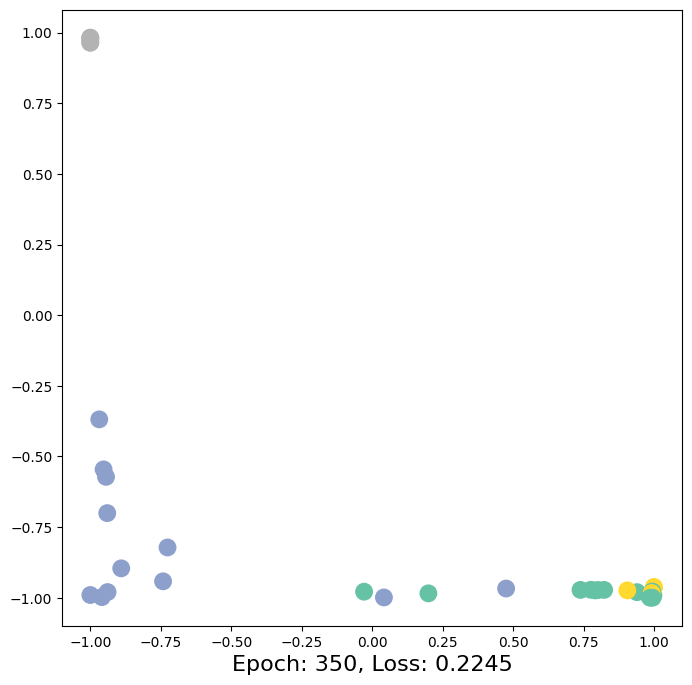

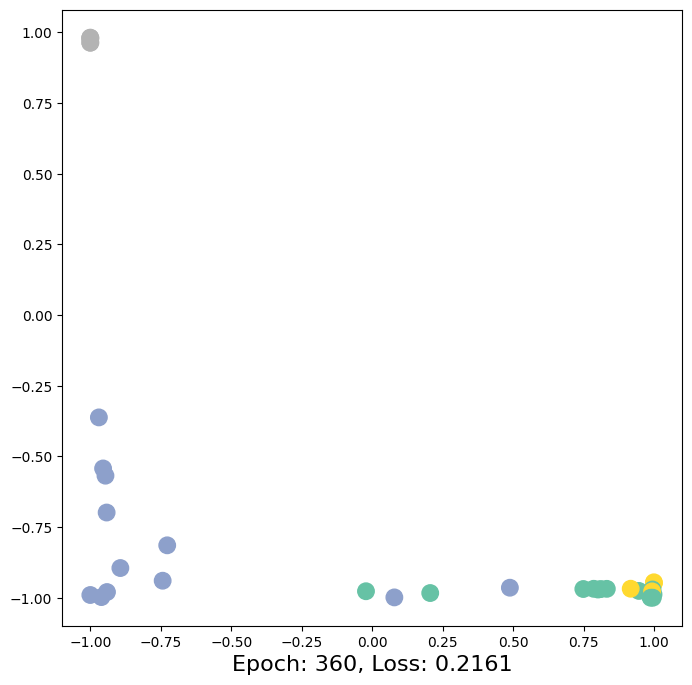

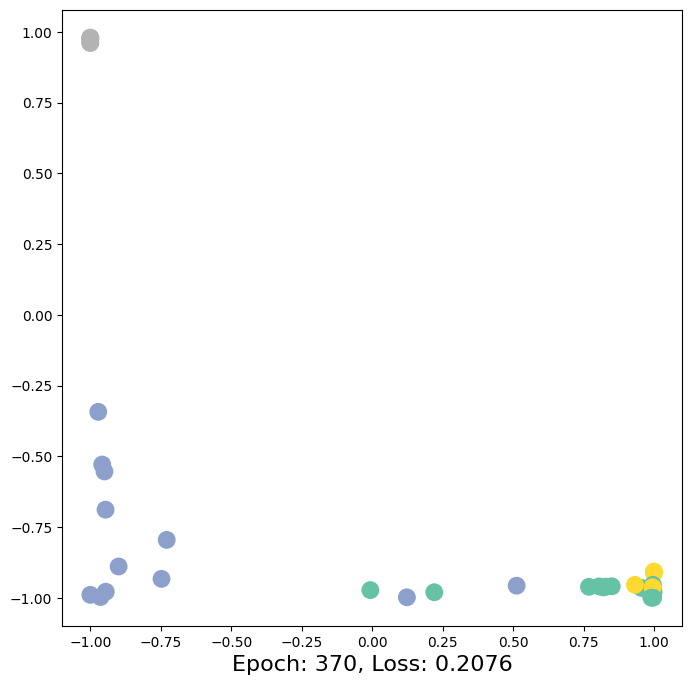

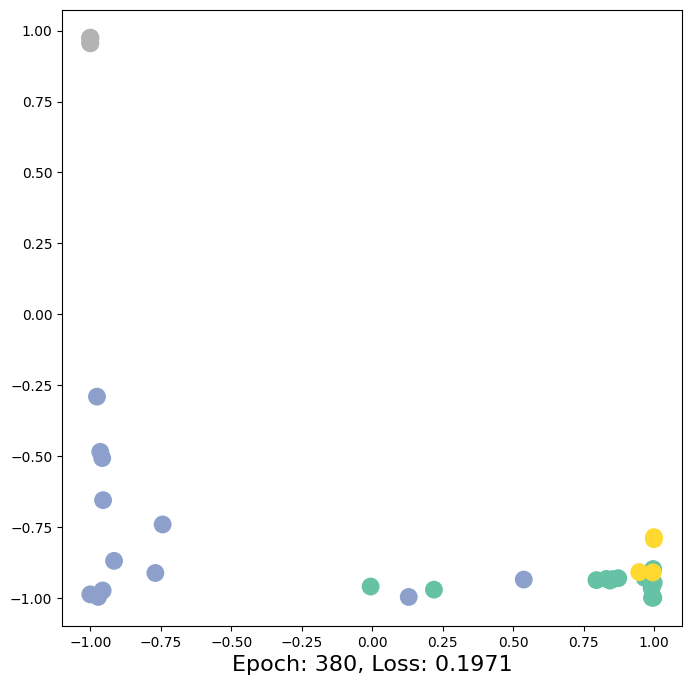

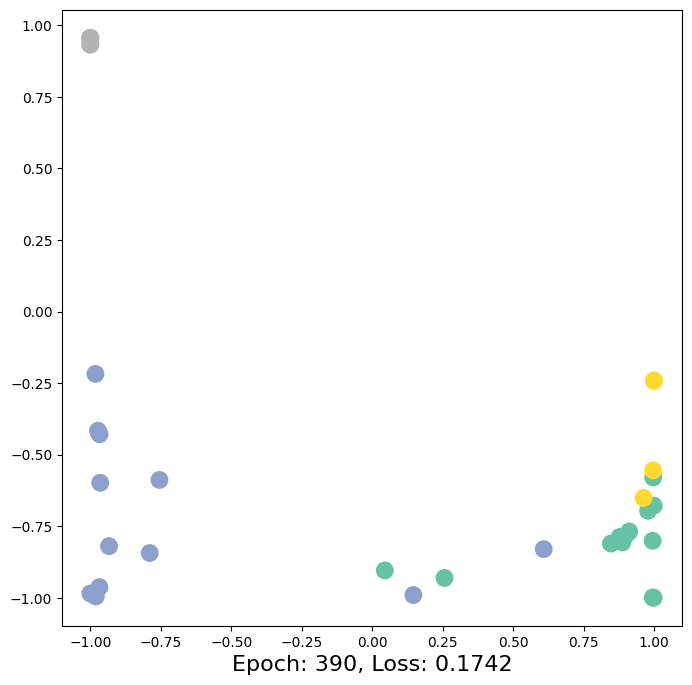

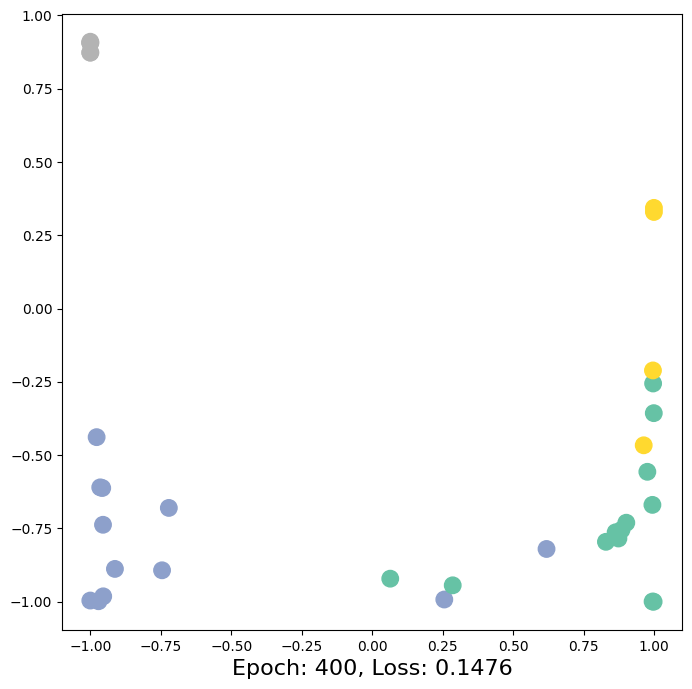

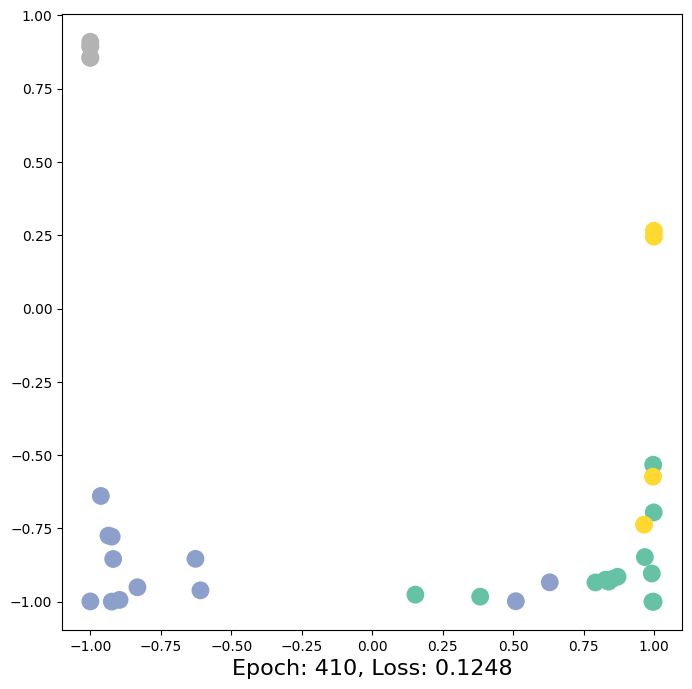

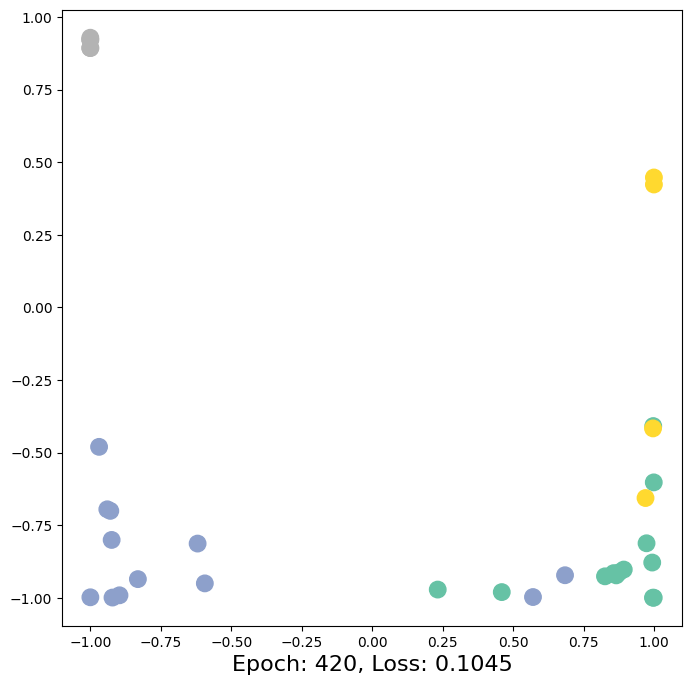

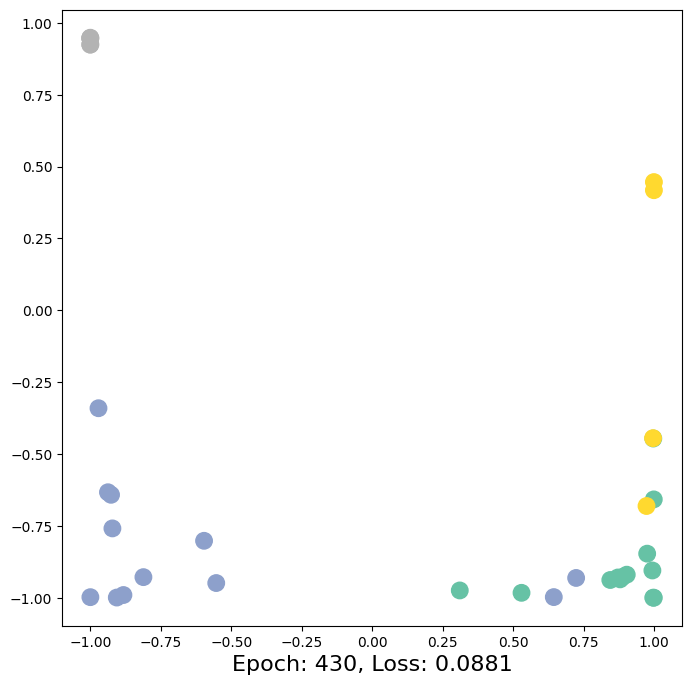

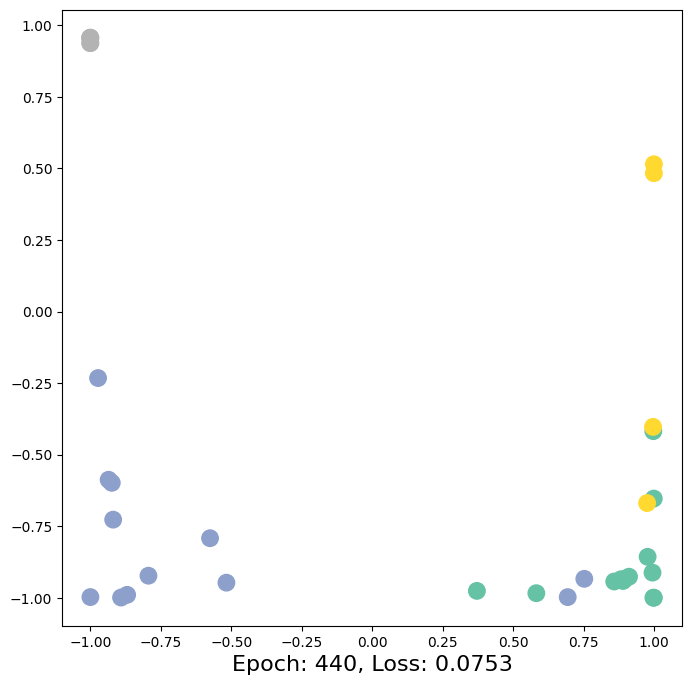

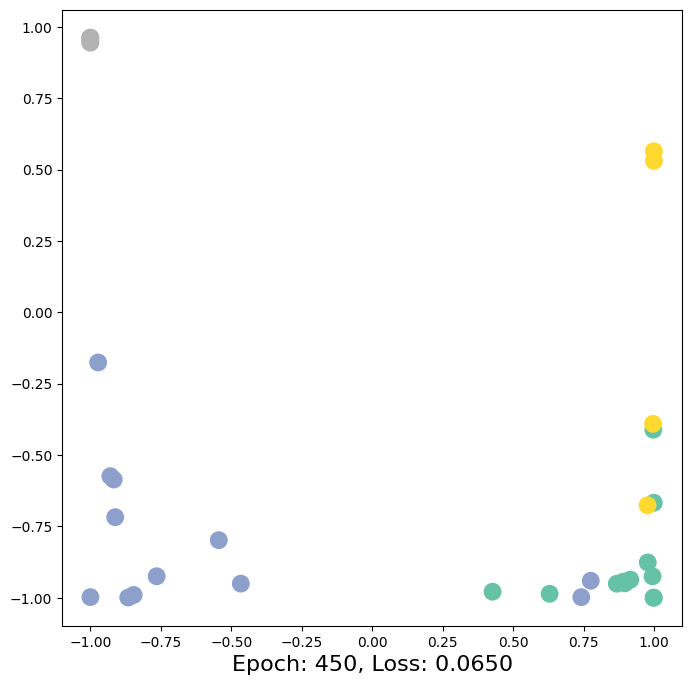

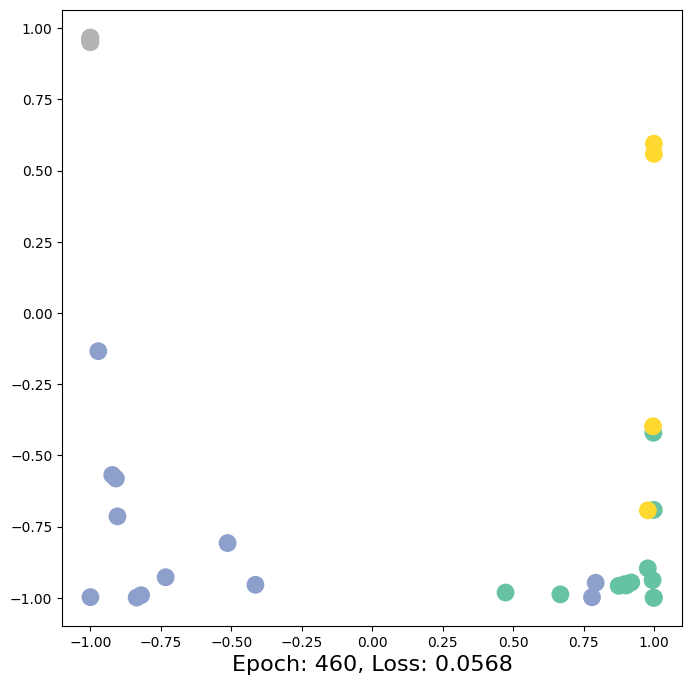

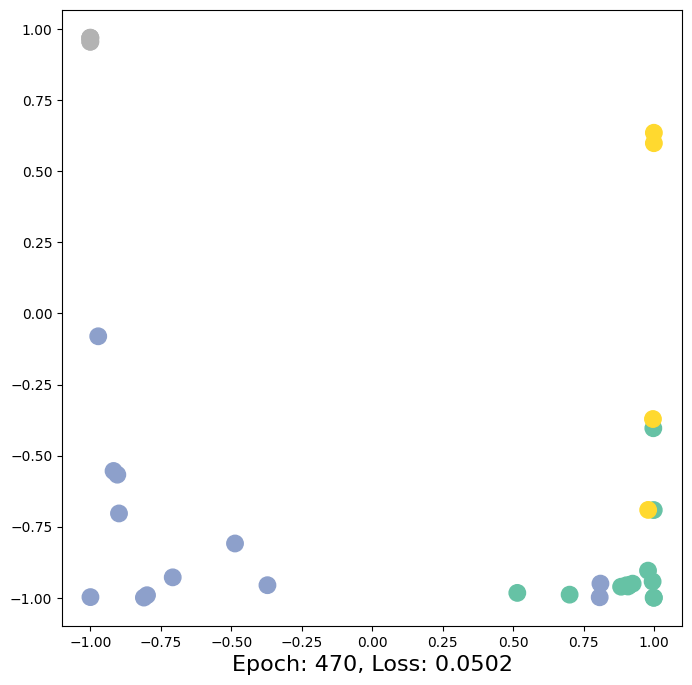

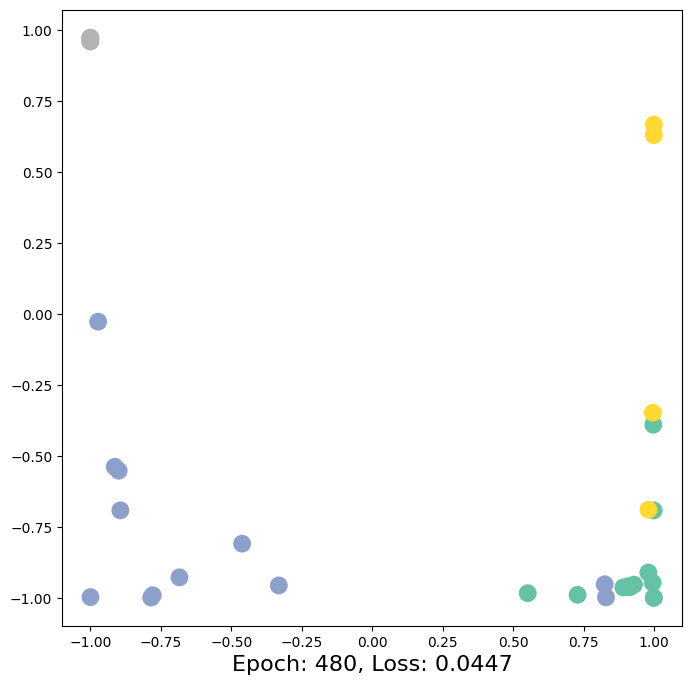

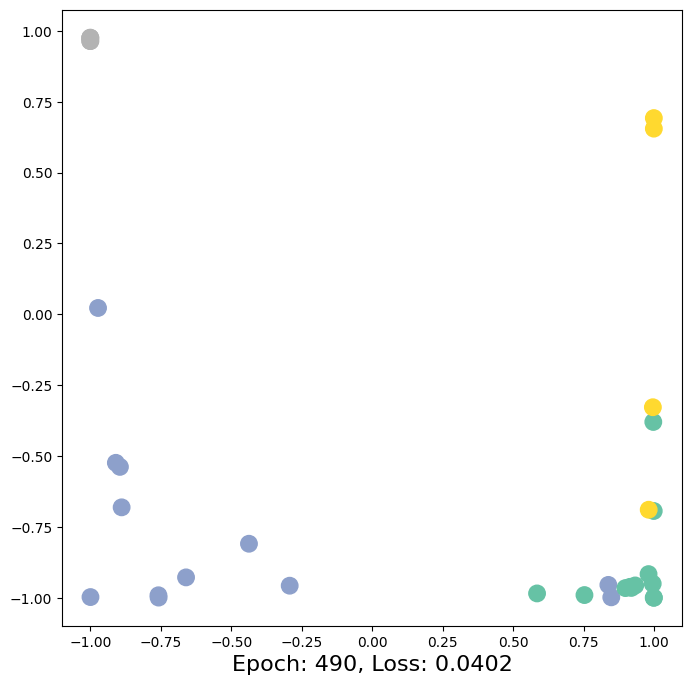

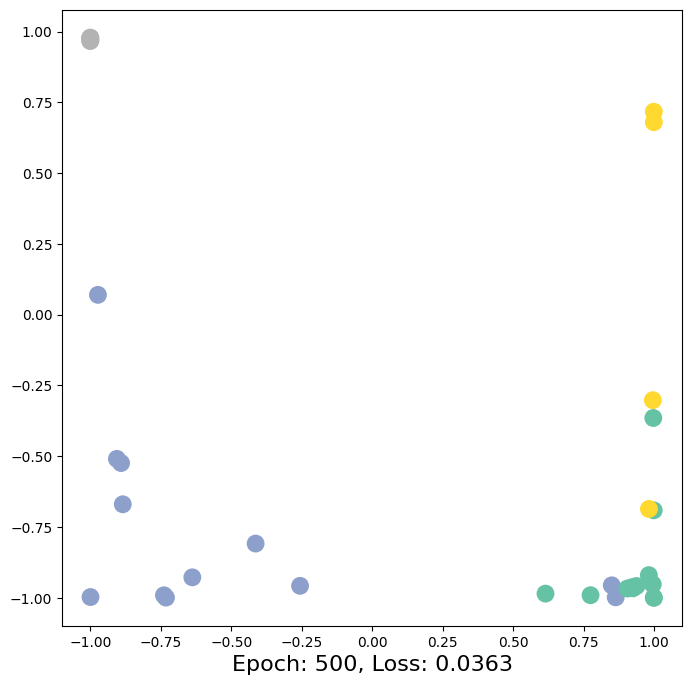

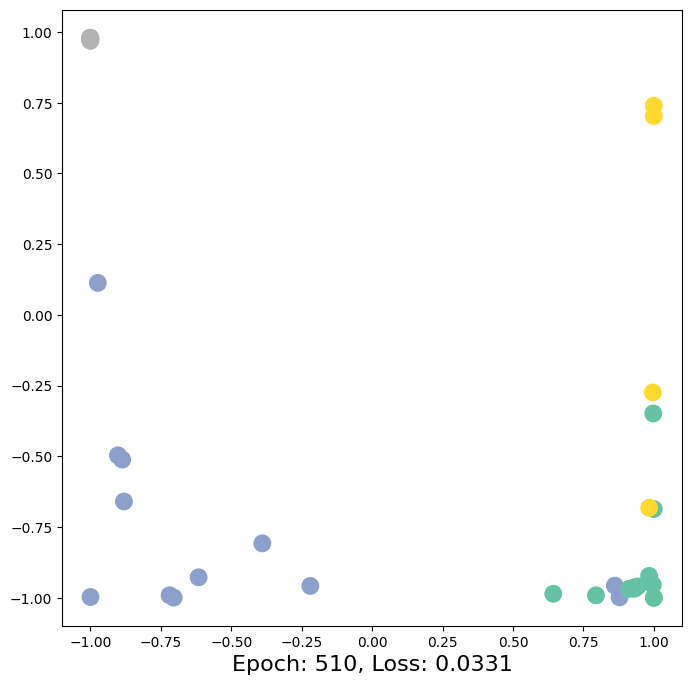

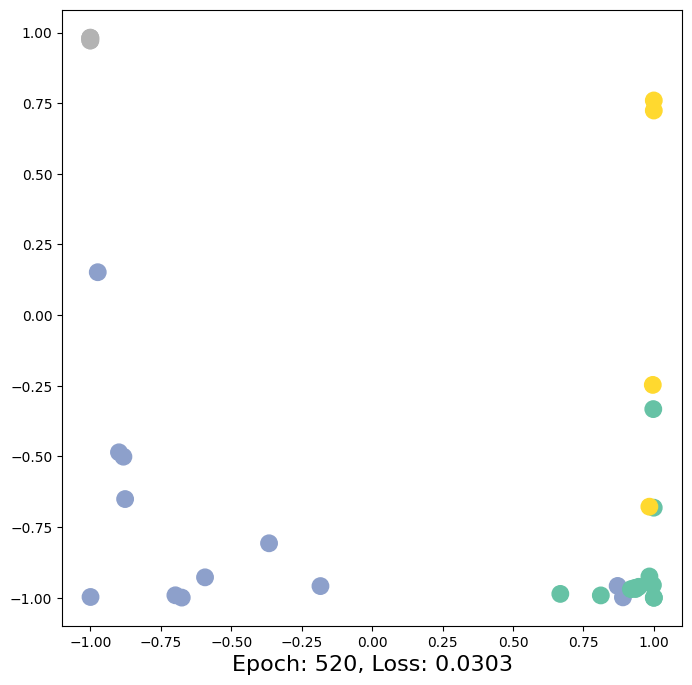

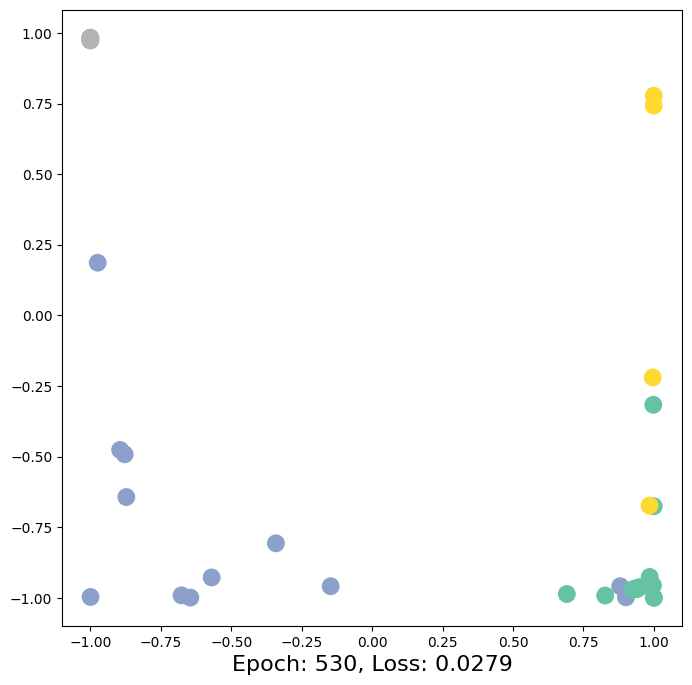

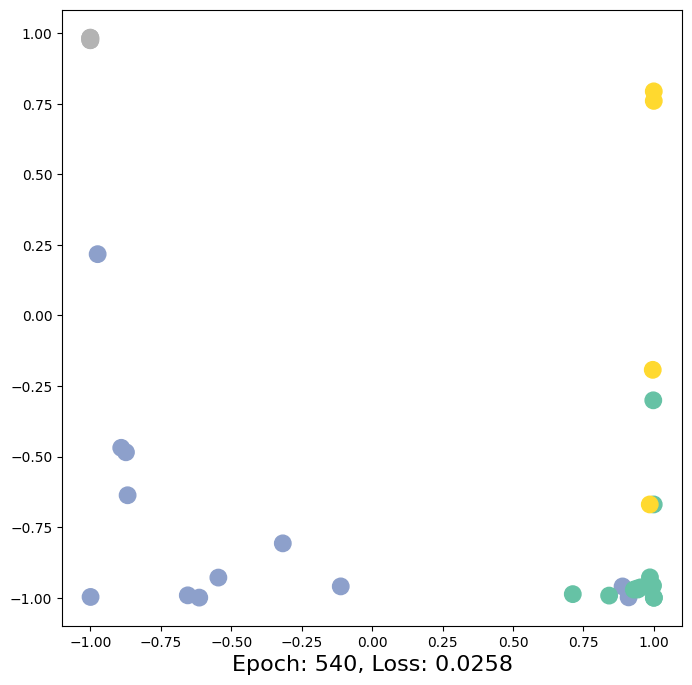

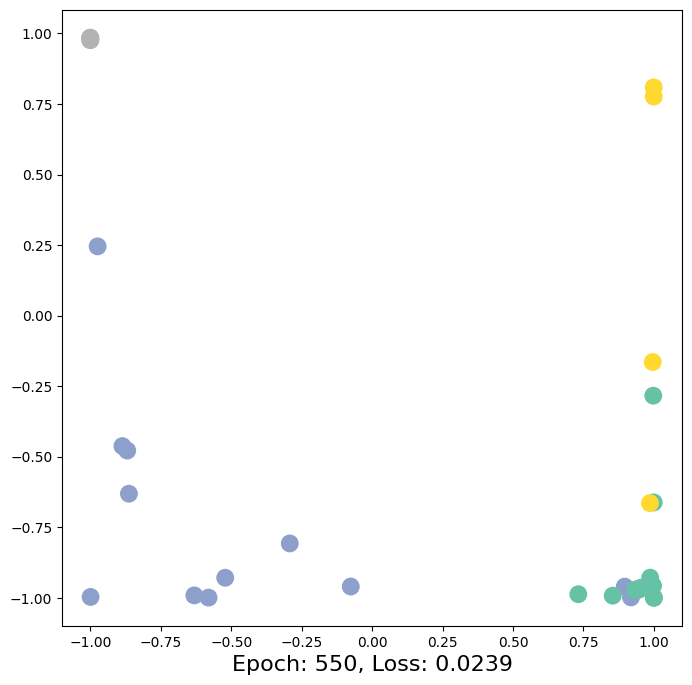

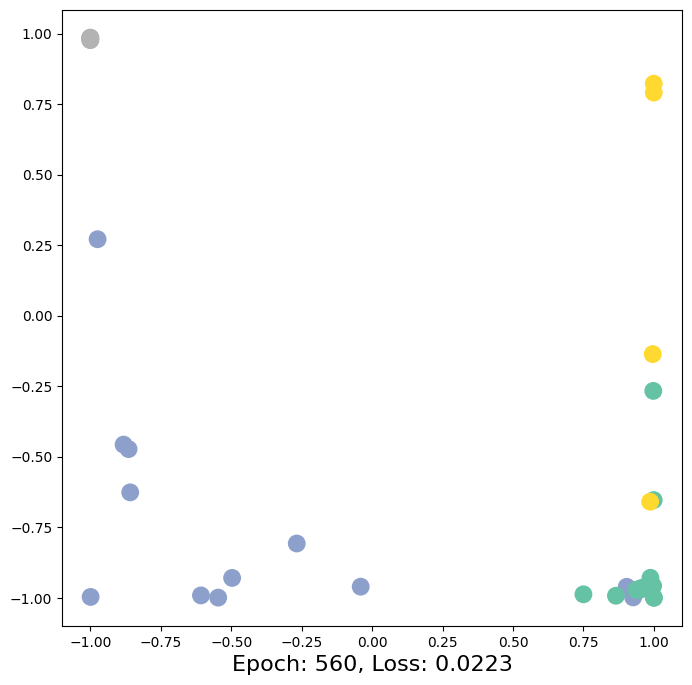

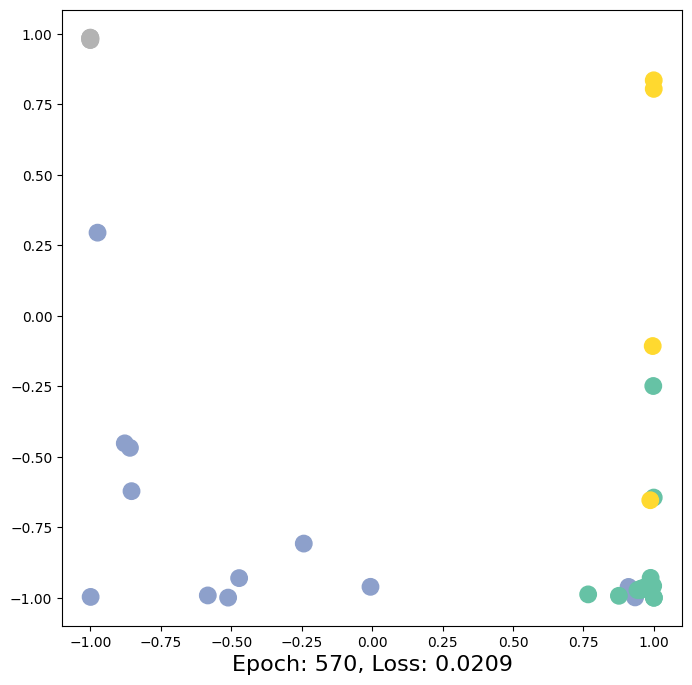

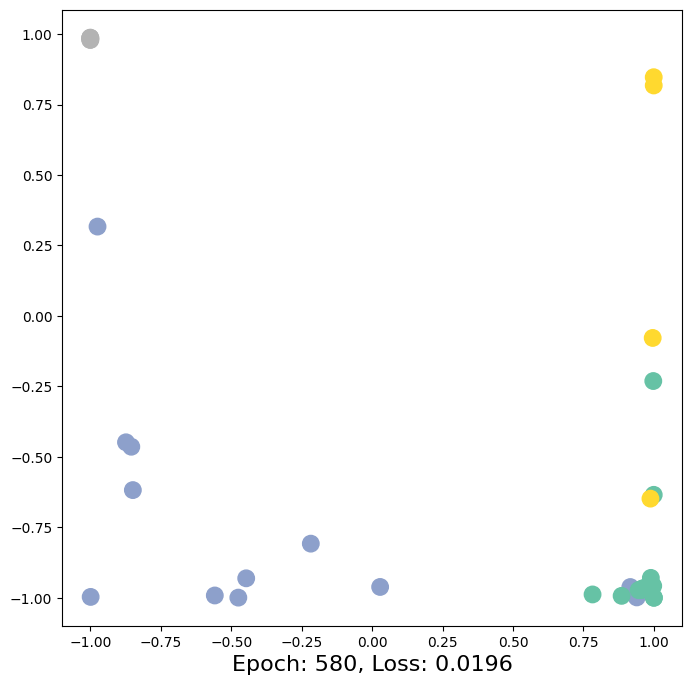

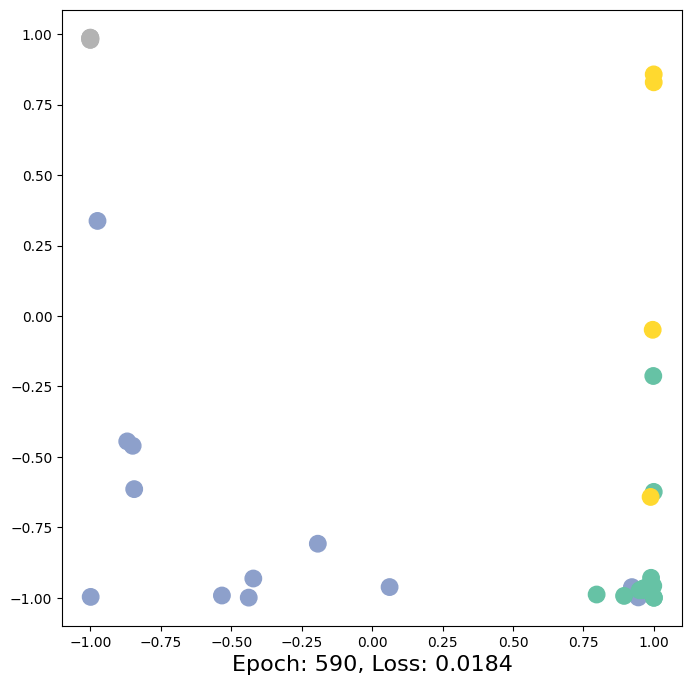

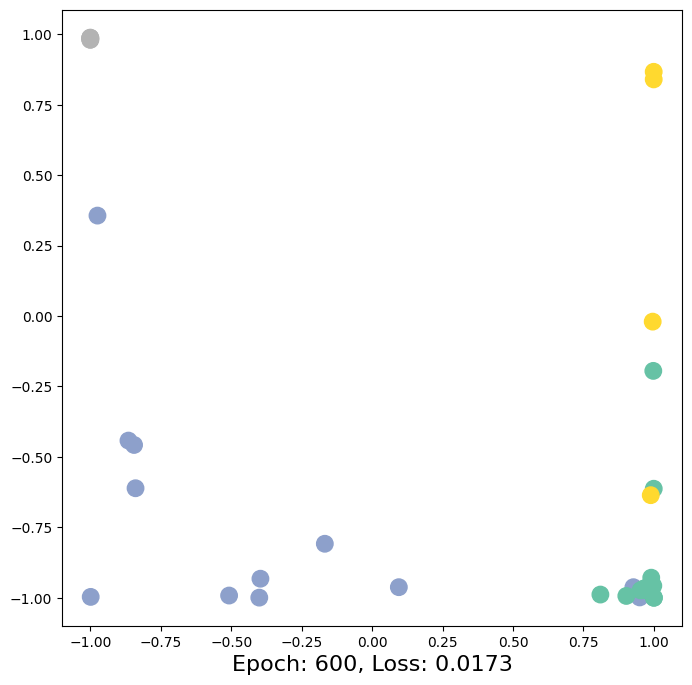

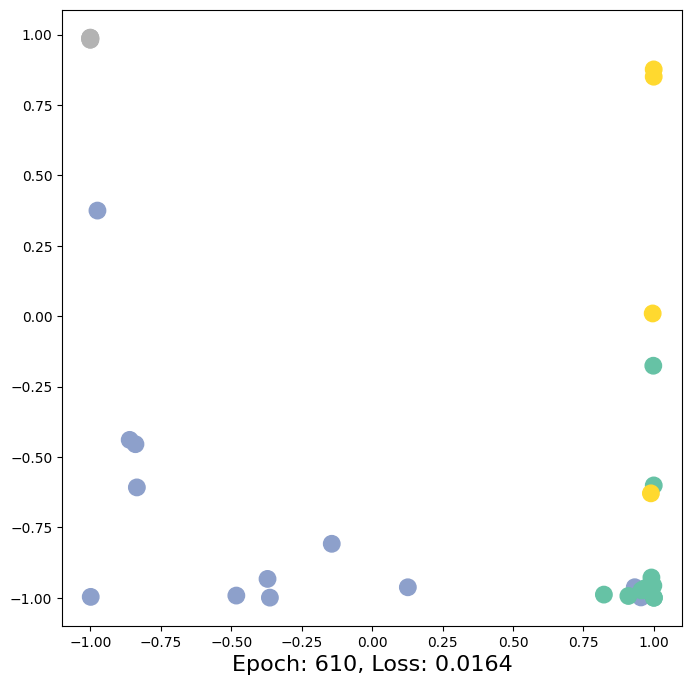

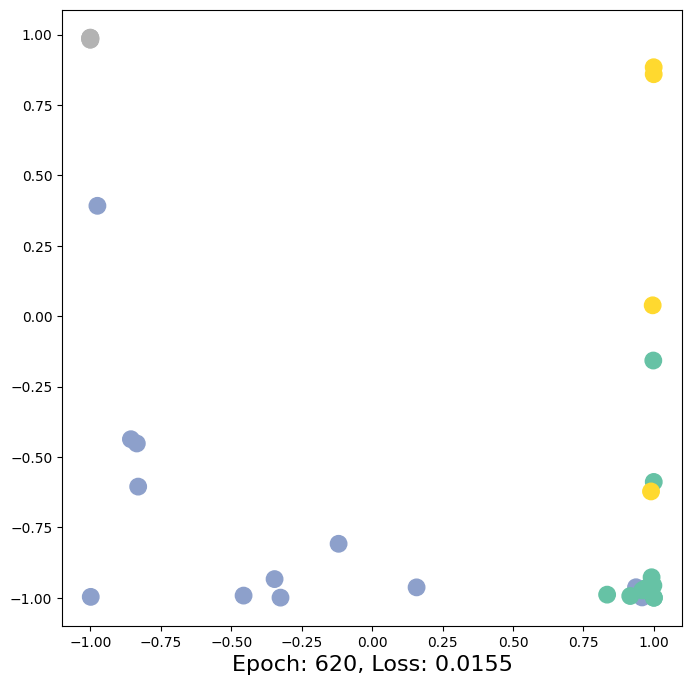

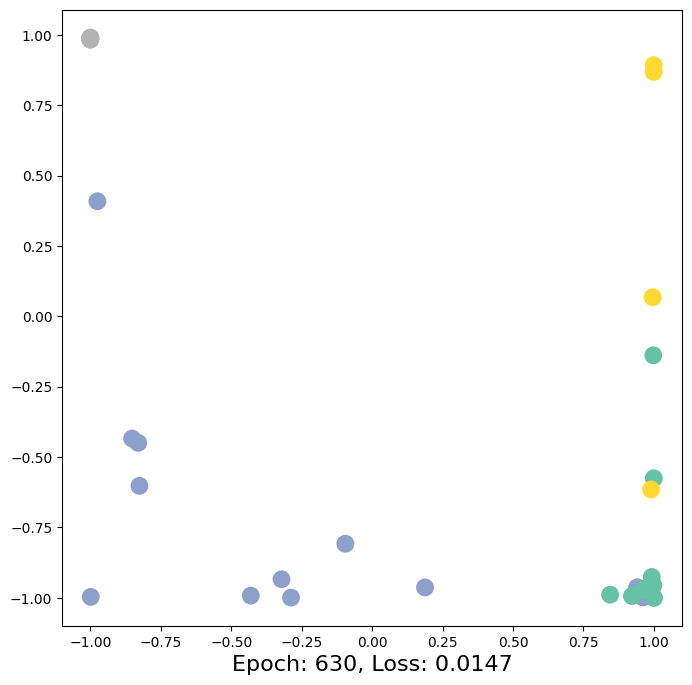

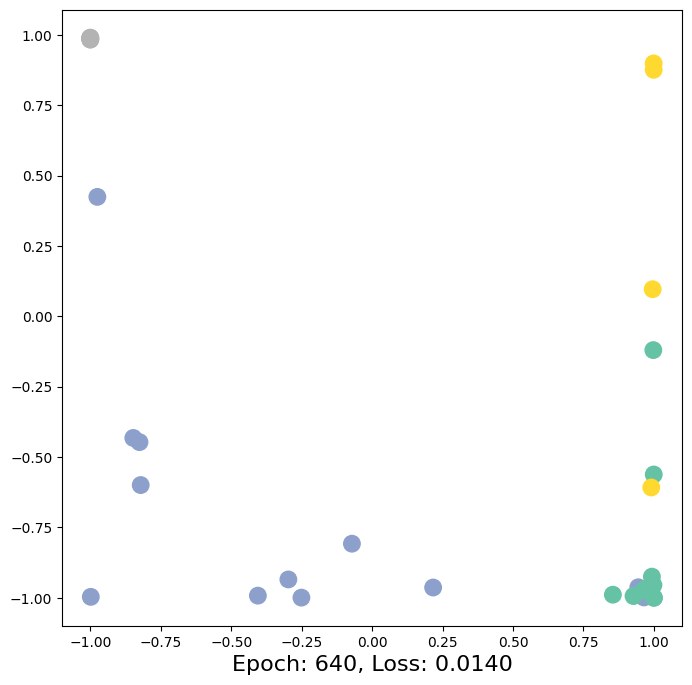

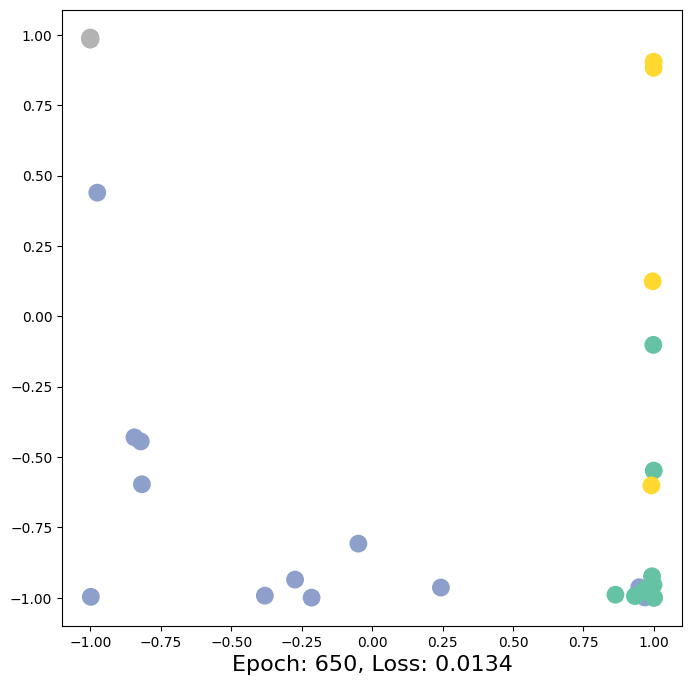

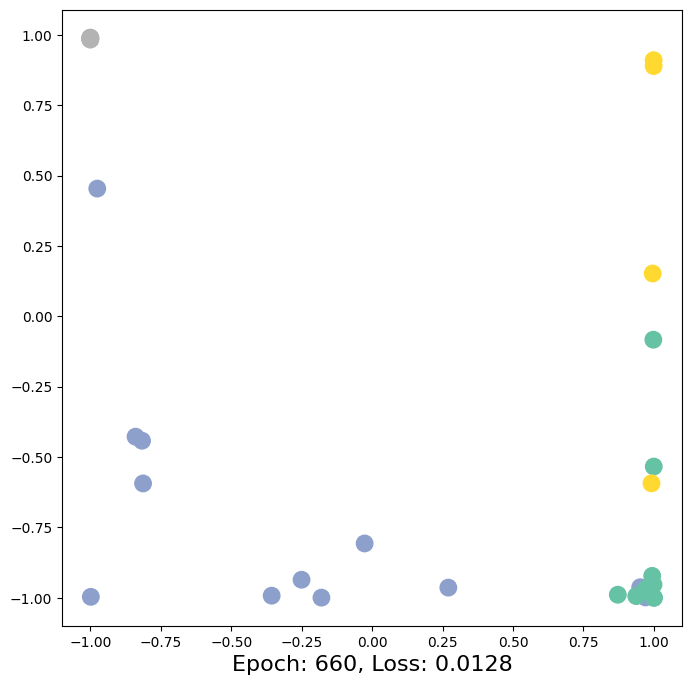

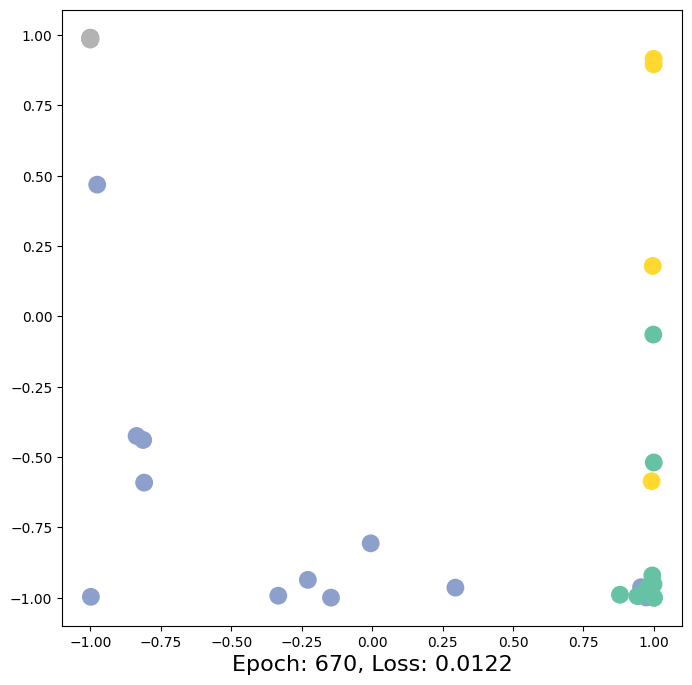

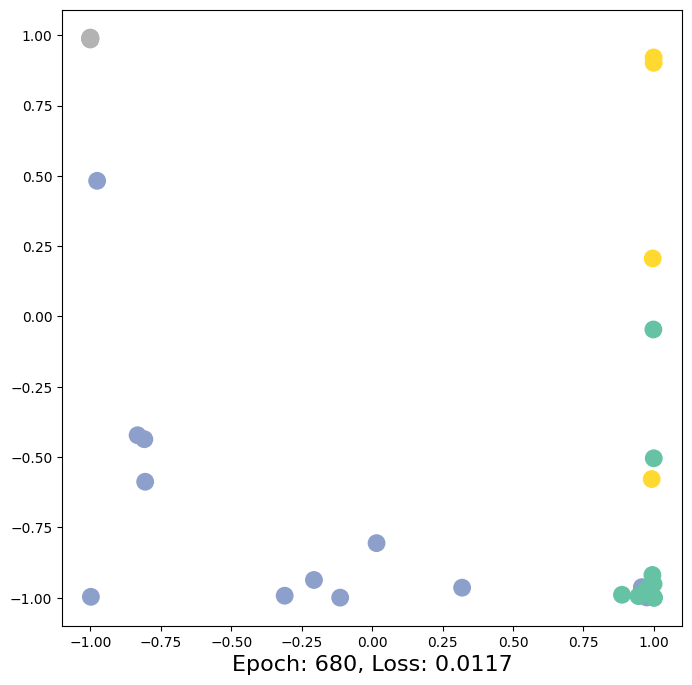

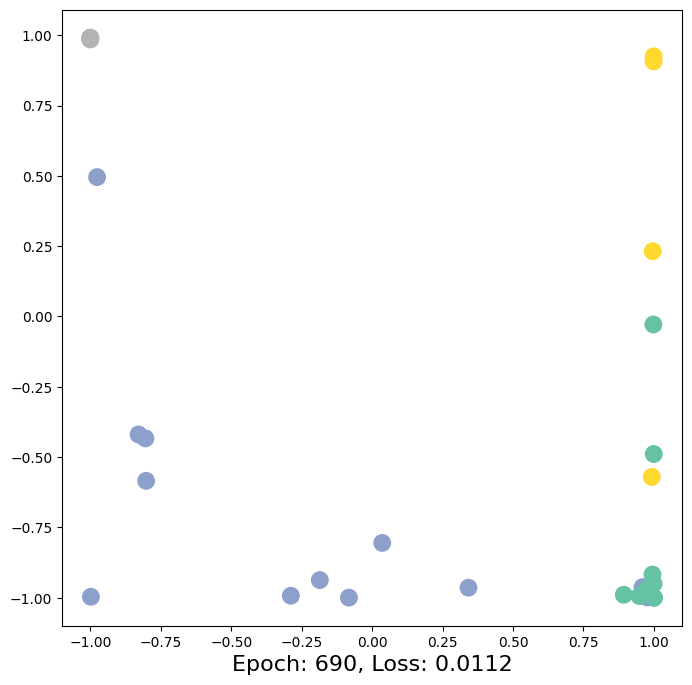

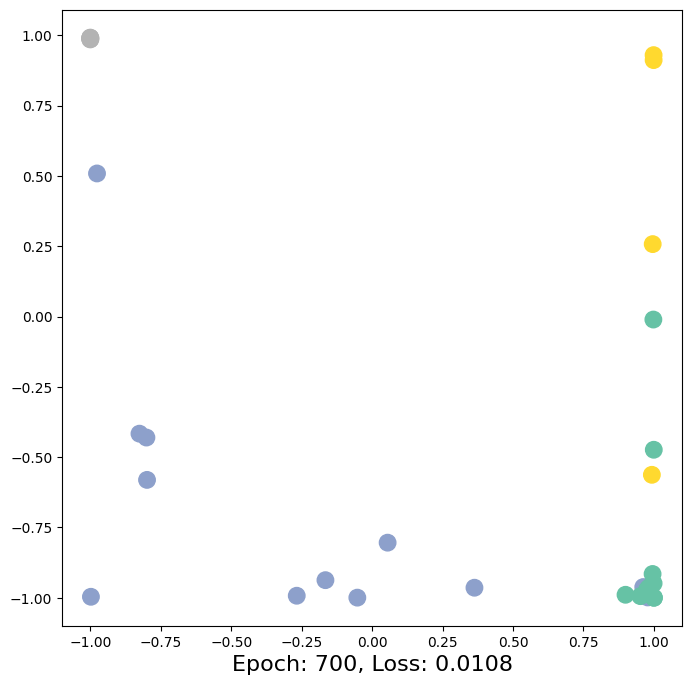

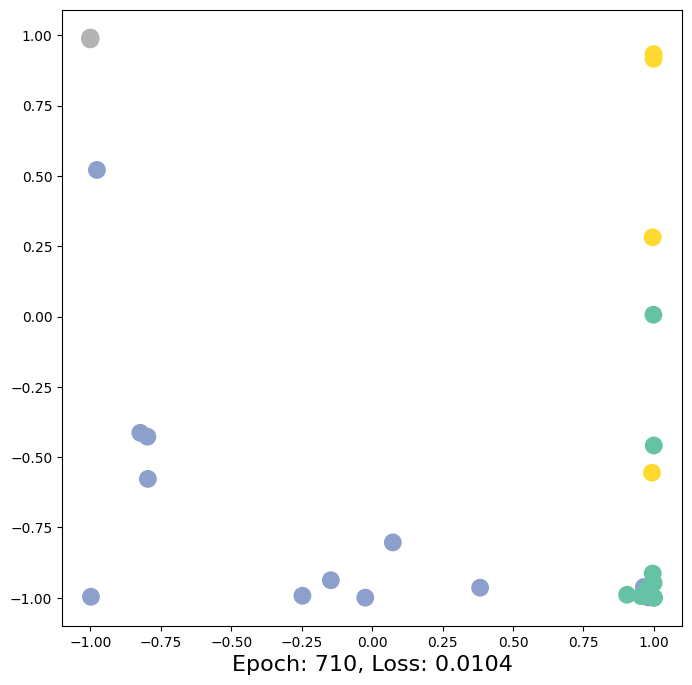

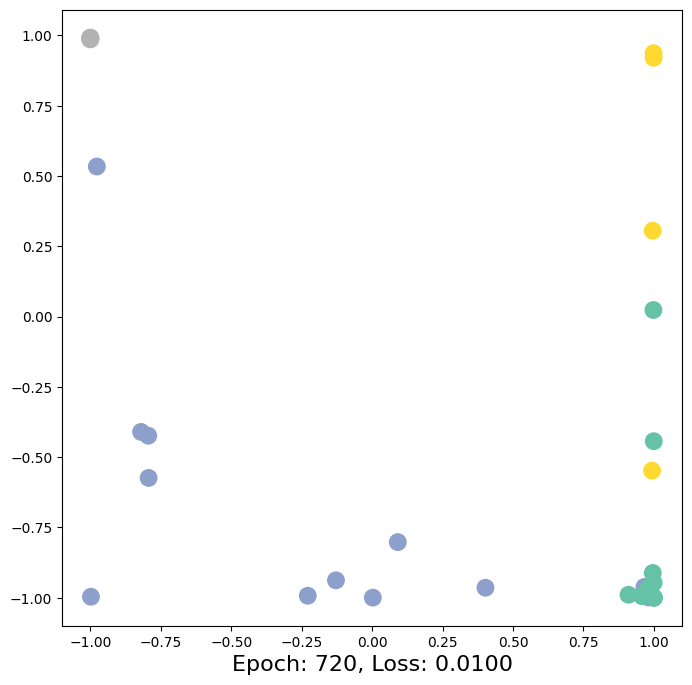

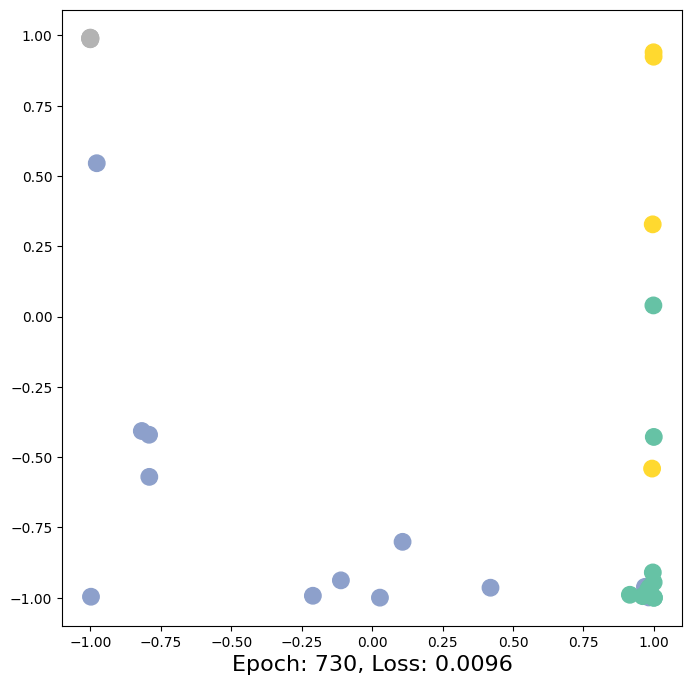

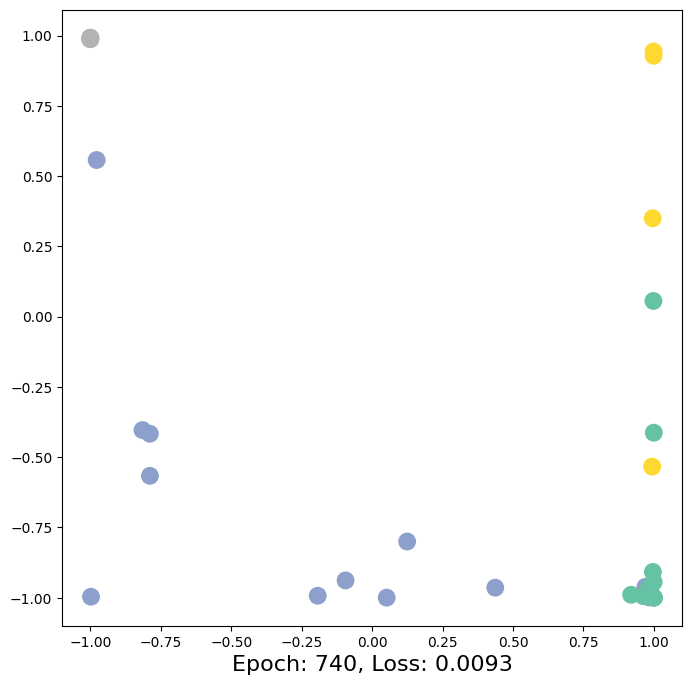

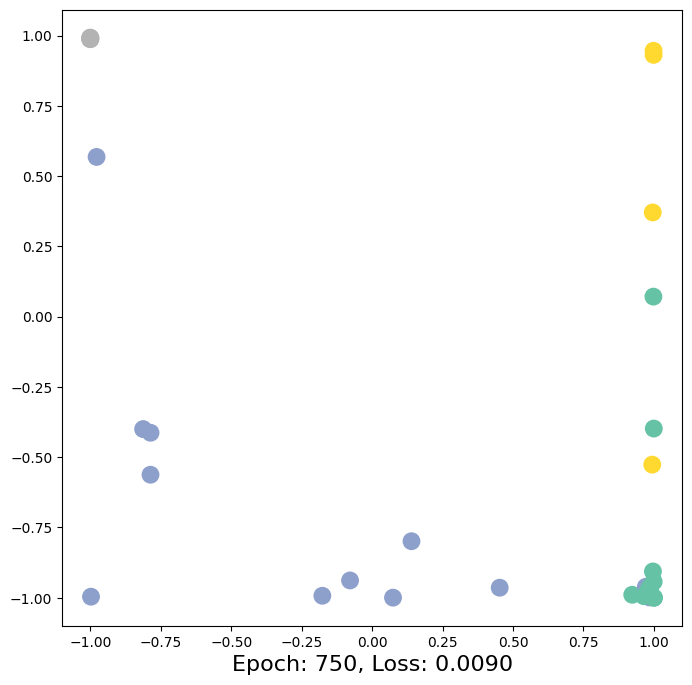

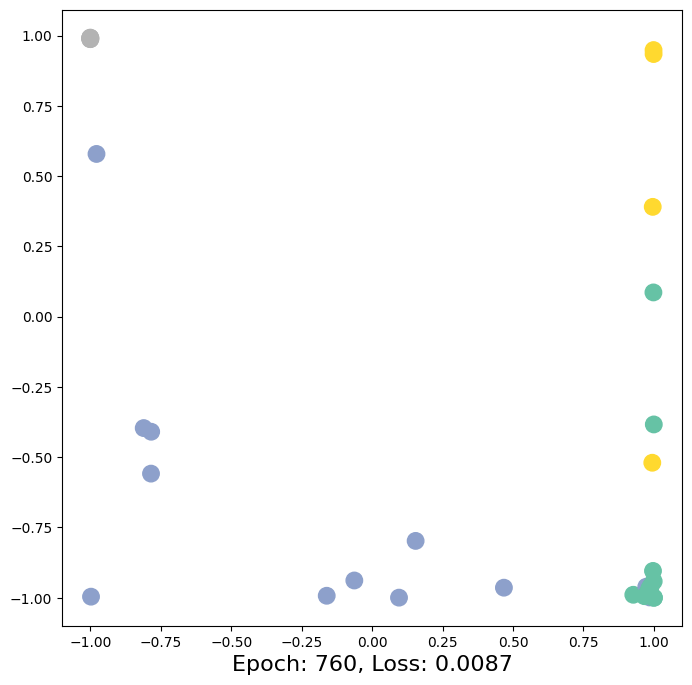

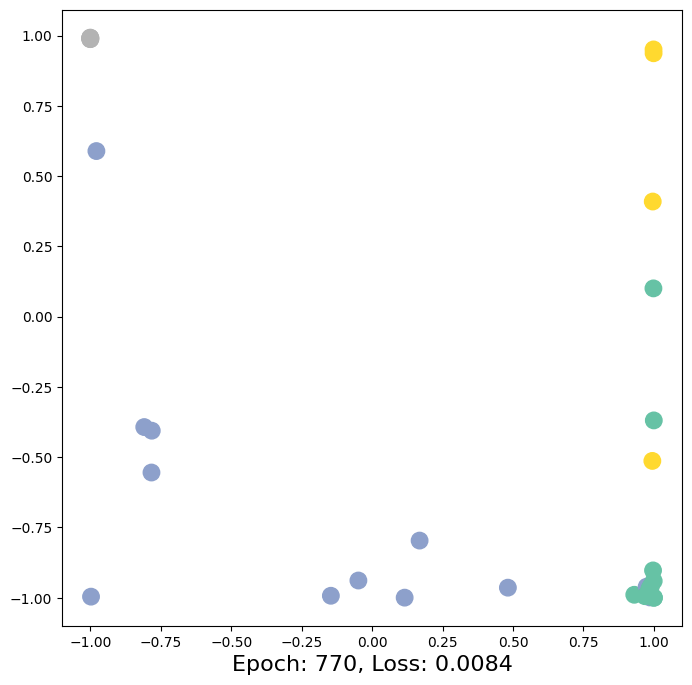

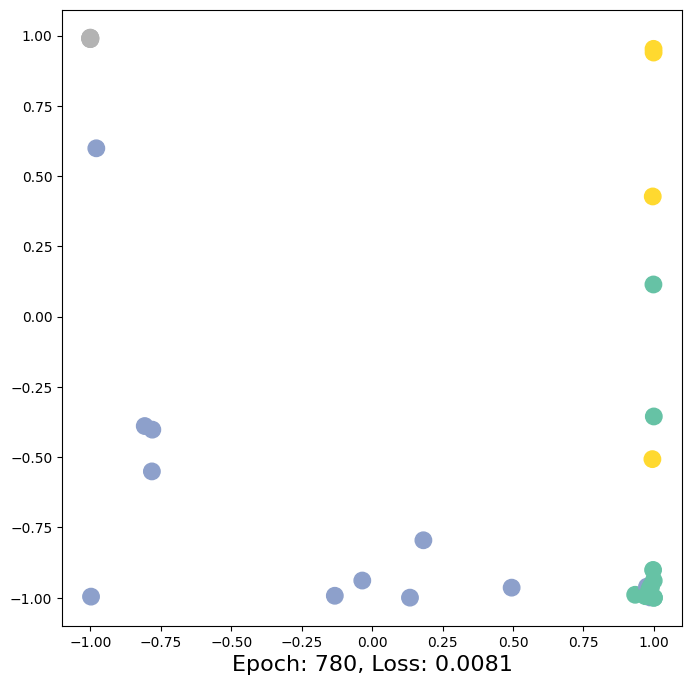

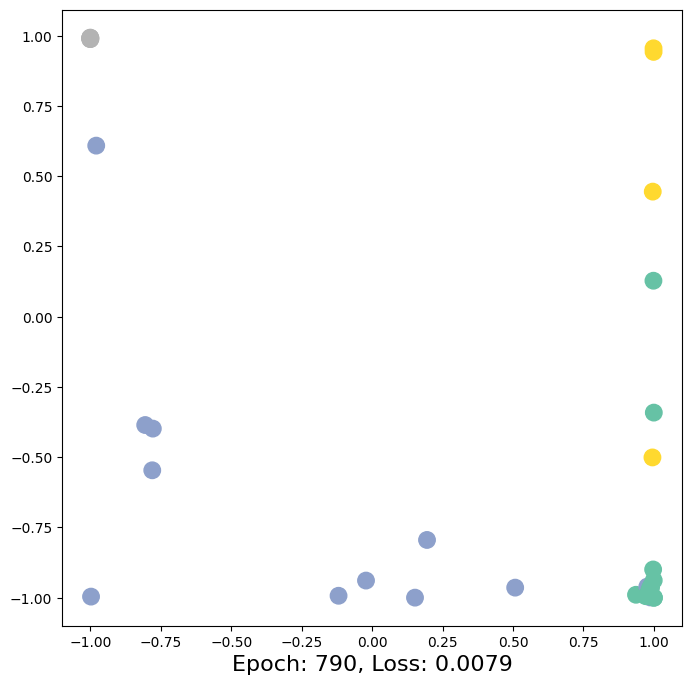

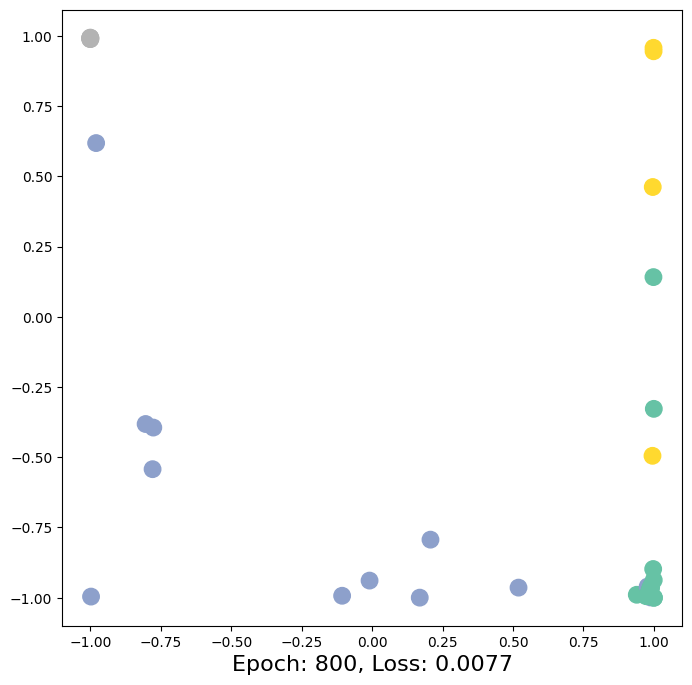

In [12]:
import time
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))

# Aquí definimos nuestro modelo, función de pérdida y optimizador
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()  # resetear gradientes
    out, h = model(data.x, data.edge_index)  # forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # calcular pérdida basados en los nodos de training
    loss.backward()  # backward pass.
    optimizer.step()  # actualización de pesos (guiados por el gradiente).
    return loss, h

for epoch in range(801):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

Luego de entrenar vemos que logra separar mejor las clases (colores) aunque no es perfecto, lo cual es esperable dado el grafo de entrada, que no tiene informacion muy discriminativa para nodos intermedios (que por conectividad podian asignarse a cualquiera de las clases indistintamente, en cierta forma)

## Ejemplo más avanzado de clasificación de nodos

En este ejemplo usaremos un grafo más complejo, llamado "Cora" que contiene información de publicaciones (papers), cada uno con features indicando la presencia o ausencia de ciertas palabras clave, y una clase (categoría del paper). El grafo se construye mediante las citas de un paper referenciando a otro.

In [13]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0] # Obtener el primer (y unico) grafo, como objeto de clase Data
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Processing...
Done!


In [14]:
def train(some_model, some_data):
      some_model.train()
      optimizer.zero_grad()  # resetear gradientes
      out = some_model(some_data.x)  # forward pass.
      loss = criterion(out[some_data.train_mask], some_data.y[some_data.train_mask])  # calcular pérdida basados en los nodos de training
      loss.backward()  # backward pass.
      optimizer.step()  # actualización de pesos (guiados por el gradiente).
      return loss

def test(some_model, some_data):
      some_model.eval()
      out = some_model(some_data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[some_data.test_mask] == some_data.y[some_data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(some_data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

Para tener un punto de comparacion, a continuación crearemos un clasificador tipo MLP que sea capaz de distinguir entre las distintas categorías de papers a partir de los features (ignorando el gráfico)

In [15]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

# Aquí creamos nuestro modelo, función de pérdida y optimizador
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

for epoch in range(1, 201):
    loss = train(model, data)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [16]:
test_acc = test(model, data)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


Ahora que sabemos el rendimiento de un modelo tipo MLP, probemos el rendimiento con un modelo para grafos

In [17]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

Antes que todo revisemos cómo separa las clases antes de empezar a entrenar

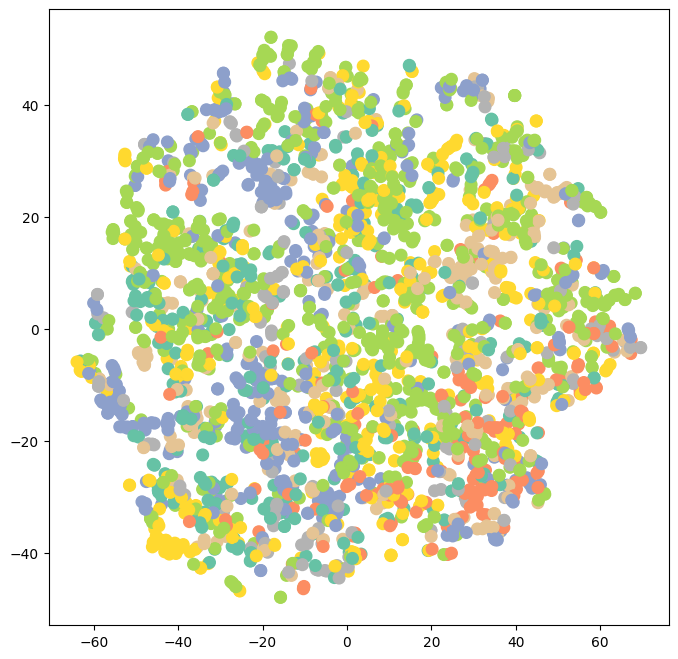

In [18]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y, tsne=True)

Ahora repitamos el entrenamiento, pero esta vez usando la GCN

In [19]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()




for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9460
Epoch: 002, Loss: 1.9412
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9308
Epoch: 005, Loss: 1.9216
Epoch: 006, Loss: 1.9137
Epoch: 007, Loss: 1.9078
Epoch: 008, Loss: 1.8986
Epoch: 009, Loss: 1.8868
Epoch: 010, Loss: 1.8825
Epoch: 011, Loss: 1.8701
Epoch: 012, Loss: 1.8614
Epoch: 013, Loss: 1.8486
Epoch: 014, Loss: 1.8323
Epoch: 015, Loss: 1.8344
Epoch: 016, Loss: 1.8186
Epoch: 017, Loss: 1.8031
Epoch: 018, Loss: 1.7980
Epoch: 019, Loss: 1.7813
Epoch: 020, Loss: 1.7766
Epoch: 021, Loss: 1.7478
Epoch: 022, Loss: 1.7385
Epoch: 023, Loss: 1.7304
Epoch: 024, Loss: 1.7120
Epoch: 025, Loss: 1.7010
Epoch: 026, Loss: 1.6917
Epoch: 027, Loss: 1.6672
Epoch: 028, Loss: 1.6382
Epoch: 029, Loss: 1.6474
Epoch: 030, Loss: 1.6297
Epoch: 031, Loss: 1.6014
Epoch: 032, Loss: 1.5760
Epoch: 033, Loss: 1.5732
Epoch: 034, Loss: 1.5705
Epoch: 035, Loss: 1.5443
Epoch: 036, Loss: 1.5131
Epoch: 037, Loss: 1.4721
Epoch: 038, Loss: 1.4774
Epoch: 039, Loss: 1.4380
Epoch: 040, Loss: 1.4553


In [20]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8080


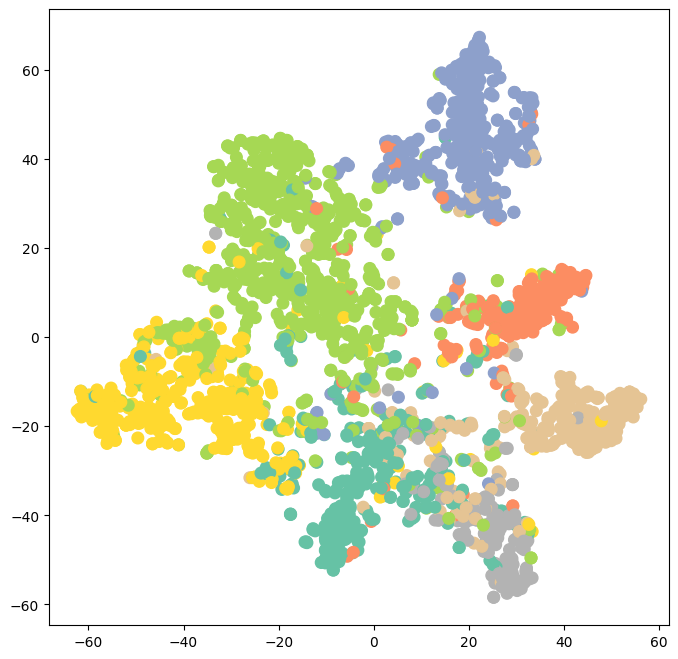

In [21]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y, tsne=True)

Con esto vemos que la GCN hace un muy buen trabajo separando las clases, gracias a que considera la informacion de conectividad de los nodos.

## Ejemplo de clasificación de Grafos

En algunos casos, en lugar de querer clasificar nodos, nos interesa clasificar grafos completos. A continuación haremos clasificación de moléculas (a partir del grafo que representa los enlaces entre los átomos que la componen).

Existen muchos datasets (algunos enormes) con este tipo de información. A continuación usaremos el **MUTAG dataset**, que es más pequeño. Este dataset clasifica moléculas según si inhiben o no la replicación del virus VIH.

Si inspeccionamos el dataset, veremos que tiene 188 grafos. Podemos inspeccionar cada uno por separado (en el ejemplo, revisaremos solo uno, lo cualo se refleja en la linea data = dataset[15], es decir, tomamos el grafo de indice 15)

In [22]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


print('-'*50+"\nInformation of the Graph #15")
data = dataset[15] # obtengamos uno de los 188 grafos
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 188
Number of features: 7
Number of classes: 2
--------------------------------------------------
Information of the Graph #15
Number of nodes: 22
Number of edges: 50
Average node degree: 2.27
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


PyTorch Geometric entrega funcionalidades para desordenar de manera aleatoria el orden de los grafos. Usaremos esa herramienta para dividir nuestro dataset en 150 para training y los 38 restantes para test:

In [23]:
from torch_geometric.loader import DataLoader

torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Number of training graphs: 150
Number of test graphs: 38


Ahora crearemos nuestra GNN compuesto de tres convoluciones de grafos y un clasificador lineal final.

In [24]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Calcular los embeddings de los nodos
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Leer los embeddings de todos los nodos (Readout)
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Aplicar dropout y un clasificador lineal
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

Definimos los metodos de train y test, identicos a los que usariamos en una red convolucional como las que hemos visto en clases anteriores.

In [25]:
def train(loader, model):
    model.train()
    for data in loader:
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss.backward()
         optimizer.step()
         optimizer.zero_grad()

def test(loader, model):
     model.eval()
     correct = 0
     for data in loader:
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Usar la clase con mayor probabilidad
         correct += int((pred == data.y).sum())  # Comparar con las etiquetas reales
     return correct / len(loader.dataset)  # Retornar el porcentaje de clasificaciones correctas

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    train(train_loader, model)
    train_acc = test(train_loader, model)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

Epoch: 001, Train Acc: 0.6467
Epoch: 002, Train Acc: 0.6467
Epoch: 003, Train Acc: 0.6467
Epoch: 004, Train Acc: 0.6467
Epoch: 005, Train Acc: 0.6467
Epoch: 006, Train Acc: 0.6867
Epoch: 007, Train Acc: 0.7133
Epoch: 008, Train Acc: 0.7467
Epoch: 009, Train Acc: 0.7133
Epoch: 010, Train Acc: 0.7200
Epoch: 011, Train Acc: 0.7267
Epoch: 012, Train Acc: 0.7067
Epoch: 013, Train Acc: 0.7200
Epoch: 014, Train Acc: 0.7333
Epoch: 015, Train Acc: 0.7200
Epoch: 016, Train Acc: 0.7133
Epoch: 017, Train Acc: 0.7333
Epoch: 018, Train Acc: 0.7600
Epoch: 019, Train Acc: 0.7200
Epoch: 020, Train Acc: 0.7267
Epoch: 021, Train Acc: 0.7533
Epoch: 022, Train Acc: 0.7533
Epoch: 023, Train Acc: 0.7267
Epoch: 024, Train Acc: 0.7400
Epoch: 025, Train Acc: 0.7533
Epoch: 026, Train Acc: 0.7533
Epoch: 027, Train Acc: 0.7400
Epoch: 028, Train Acc: 0.7333
Epoch: 029, Train Acc: 0.7467
Epoch: 030, Train Acc: 0.7467
Epoch: 031, Train Acc: 0.7600
Epoch: 032, Train Acc: 0.7667
Epoch: 033, Train Acc: 0.7600
Epoch: 034

In [26]:
test_acc = test(test_loader, model)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.7368


Vemos que el modelo logra un buen rendimiento a pesar de usar una red muy sencilla y muy pocos datos

## (Material Opcional) Probando la técnica de Morris et al.

Algunos papers ([Xu et al. (2018)](https://arxiv.org/abs/1810.00826), [Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), muestran que la normalización de vecinos perjudican la expresividad de las GNN para distinguir ciertos tipos de estructuras de grafos.


[Morris et al. (2018)](https://arxiv.org/abs/1810.02244) quita la normalización en la etapa de agregación de mensajes y agrega una skip-connection para permitir que la red preserve la información original de cada nodo:

$$
\mathbf{h}_i^{(t+1)} = \mathbf{W}^{(t + 1)}_A \mathbf{h}_i^{(t)} + \mathbf{W}^{(t + 1)}_B \sum_{j \in \mathcal{N}(i)} \mathbf{h}_j^{(t)}
$$

Para usar esta capa basta con usar su implementación en la clase [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) de PyTorch Geometric en lugar de la GCNConv que usamos *anteriormente*.

In [30]:
from torch_geometric.nn import GraphConv


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [31]:
model = GNN(hidden_channels=64)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(train_loader, model)
    train_acc = test(train_loader, model)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)
Epoch: 001, Train Acc: 0.7333
Epoch: 002, Train Acc: 0.6467
Epoch: 003, Train Acc: 0.6467
Epoch: 004, Train Acc: 0.6467
Epoch: 005, Train Acc: 0.6533
Epoch: 006, Train Acc: 0.7267
Epoch: 007, Train Acc: 0.7133
Epoch: 008, Train Acc: 0.7333
Epoch: 009, Train Acc: 0.7733
Epoch: 010, Train Acc: 0.7667
Epoch: 011, Train Acc: 0.7800
Epoch: 012, Train Acc: 0.7733
Epoch: 013, Train Acc: 0.7933
Epoch: 014, Train Acc: 0.7733
Epoch: 015, Train Acc: 0.7933
Epoch: 016, Train Acc: 0.7800
Epoch: 017, Train Acc: 0.7667
Epoch: 018, Train Acc: 0.8000
Epoch: 019, Train Acc: 0.8067
Epoch: 020, Train Acc: 0.7733
Epoch: 021, Train Acc: 0.7867
Epoch: 022, Train Acc: 0.7867
Epoch: 023, Train Acc: 0.8067
Epoch: 024, Train Acc: 0.7733
Epoch: 025, Train Acc: 0.7867
Epoch: 026, Train Acc: 0.7800
Epoch: 027, Train Acc: 0.7800
Epoch: 028, Train Acc: 0.7867
Epoch: 0

In [32]:
test_acc = test(test_loader, model)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.8158


Con esto vemos que el pequenio cambio que introduce Morris et al. produce una mejora importante en el resultado, lo cual se explica por el hecho de que en estos casos permite a la red diferenciar la cantidad de aristas que llegan a cada nodo (una GCN comun pierde esa informacion al preservar solo el valor promedio)  

# **(Material Opcional) Trucos útiles**

##¿Qué hago si mi grafo es tan grande que no cabe en GPU?

Podemos usar una técnica llamada **Cluster-GCN**, propuesta por [Chiang et al. (2019)](https://arxiv.org/abs/1905.07953), que consiste en pre-particionar el grafo en subgrafos, de tal manera de que puedan ser usados en un minibatch.

A pesar de su simpleza, esta técnica ha resultado ser muy poderosa para trabajar con grafos enormes.

In [33]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!



Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.003
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [34]:
from torch_geometric.loader import ClusterData, ClusterLoader

cluster_data = ClusterData(data, num_parts=128)  # 1. Crear el objeto encargado de particionar en sub-grafos
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. El dataloader se encarga de mostrar sub-grafos diferentes en cada iteración

Computing METIS partitioning...


ImportError: ignored

Y listo! Ahora podemos usar este nuevo dataloader como si fuera uno normal (como en los ejemplos anteriores), y dejamos toda la responsabilidad de particionar los grafos a las clases ClusterData y ClusterLoader

## ¿Cómo creo Grafos y Dataloaders con mis propios datos?

Se puede hacer creando un objeto de tipo `Data` para cada grafo del dataset.
Ojo que aqui pusimos [...] para representar la matriz de datos propias del problema que usted busca resolver y Data(...) para representar el Dataset que usted haya creado. Por esa razon estas celdas aun no estan listas para ejecutarse.

In [35]:
nodes_features = torch.tensor([...]) # Tensor (opcional) de tamaño [num_nodes, num_features]
edges = torch.tensor([...], dtype=torch.long) # LongTensor (opcional) de tamaño [2, num_edges] representando las aristas
y = torch.tensor([...]) # Tensor (opcional) de tamaño [num_nodes, num_clases] con la(s) clase(s) de los nodos. Tipicamente num_clases es 1, pero es posible usar más

data = Data(x=nodes_features, edge_index=edges, y=y)

# opcionalmente se puede definir propiedades a la medida
data.train_idx = torch.tensor([...], dtype=torch.long)
data.test_mask = torch.tensor([...], dtype=torch.bool)

RuntimeError: ignored

In [ ]:
from torch_geometric.data import Data, DataLoader

data_list = [Data(...), ..., Data(...)]
loader = DataLoader(data_list, batch_size=32)

## ¿Cómo lo hago si quiero explorar arquitecturas de GNN más "a la medida" o usar otros modelos?

Pytorch Geometric trae implementados diversos tipos de capas que pueden ser ensamblados libremente como si se tratara de piezas de lego.

Para ver el detalle de todos los componentes disponibles, ir a
https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html

Particularmente trae implementadas todas las arquitecturas que revisamos en clases:

* graphSAGE (SAGEConv)
* gated GNN (GatedGraphConv)
* GCN (GCNConv)

Incluso tambien trae implementadas algunas capas más avanzadas y recientes (algunas de este año). Por ejemplo algunas basadas en atención o en transformer

* TransformerConv
* AGNNConv

Además trae varios modelos completos implementados
https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#models


# **Actividades**

##Actividad 1:

**En la actividad donde usamos una GCN para el dataset de "Karate Club" vimos que al aplicar una GCN sobre los datos, se puede apreciar un ligero ordenamiento de los nodos, que tiene cierta correspondencia con los grupos existentes entre los individuos. ¿De dónde proviene esa información, considerando que los pesos están aun en sus valores aleatorios iniciales?**

In [ ]:
#@title Respuesta 1

Respuesta = 'Provienen de la operatoria de la GCN que obedece a las aristas del Grafo' #@param ["seleccione una opcion", "Provienen de los features iniciales de los nodos","Provienen de los features iniciales de las aristas","Provienen de la operatoria de la GCN que obedece a las aristas del Grafo","Provienen de la operatoria de la GCN que obedece a los features de los Nodos", "Proviene de la informacion (hiperparametros) proporcionados por el usuario al crear el modelo","Proviene de la implementacion de la GCN, que inicializa el grafo en un estado inicial razonable de acuerdo con los datos","Proviene de aleatoriedades, que por ser un dataset chico parece mostrar un ordenamiento cuando en realidad no lo hay","Proviene de la arquitectura de la GCN, que al ser creada a partir de un cierto grafo, naturalmente se adapta a ese grafo"]

Debido a el promedio de la sumatoria que hace que los vecinos se parezcan entre ellos

##Actividad 2:

**En clase se mencionó que ocurre un problema cuando existen nodos que no tienen ninguna arista entrante hacia él, sino solamente aristas salientes.**
* **Describa cuál es ese problema que se produce**
* **Describa muy brevemente alguna solución (o "truco") para evitarlo.**

Se recomienda mencionar la misma solución mencionada en la clase, pero si lo desea puede proponer otra)

In [ ]:
#@title Respuesta 2.1 y 2.2

Problema = 'Como el nodo solo transmite informaci\xF3n y no recibe, solo va a estar interactuando con el mismo para actualizar la informaci\xF3n, por lo que no recibe informaci\xF3n nueva.' #@param {type:"string"}
Una_posible_solucion = 'Podemos colocar aristas inversas, de forma que todos los nodos recibir\xE1n informaci\xF3n de al menos alguien (asumiendo conectividad total)' #@param {type:"string"}

##Actividad 3:

**Supongamos que tenemos un grafo donde uno de los nodos está completamente aislado (sin aristas entrantes ni salientes).**
* **¿Serviría de algo la solución propuesta anteriormente?**
* **Luego de pasar por toda la red (supongamos una GCN de 3 capas/iteraciones) ¿Cómo será el estado final de ese nodo (sus features)?**

In [ ]:
#@title Respuesta 3.1 y 3.2

Sirve_la_solucion_anterior = 'No' #@param ["seleccione una opcion", "Si", "No"]
Como_es_su_estado_final = 'Identico al inicial' #@param ["seleccione una opcion", "Identico al inicial","Puede ser distinto al inicial"]

## Actividad 4:

Cuando los grafos son muy grandes y es difícil visualizarlos, una métrica útil es conocer el "grado" promedio de los nodos, que es la cantidad promedio de vecinos por nodo. Por ejemplo, un grafo de 10 nodos donde todos están conectados con todos, tendrá un grado promedio de 9 (pues cada nodo tiene 9 vecinos).

Esto es muy útil porque se ha mostrado empíricamente que para grafos muy conectados, suelen tener mejor rendimiento redes pequeñas (ej: pocos parámetros y pocas capas) mientras que cuando están muy poco conectadas suelen tener mejor rendimiento las redes más grandes.

**Asuma que tiene un grafo de Pytorch Geometric almacenado como una instancia de la clase Data, tal como los usados en este laboratorio. Escriba un código que imprima en pantalla el grado promedio de un grafo**

*Hint: En Pytorch Geometric las aristas no dirigidos se representan internamente por dos aristas (en ambas direcciones)*

*Hint 2: Está permitido copiar-pegar la respuesta en caso que la encuentre escrita entre las actividades de este jupyter notebook*

In [27]:
#@title Respuesta 4

Problema = 'data.num_edges / data.num_nodes' #@param {type:"string"}


## Actividad 5

En el siguiente código que implementa una Red Neuronal de Grafos con capas de tipo GCN para un problema de clasificación multi-clase, entrenado como suele hacerse para problemas de clasificación (CrossEntropy):

    class GCN(torch.nn.Module):
        def __init__(self):
            super(GCN, self).__init__()
            self.conv1 = GCNConv(dataset.num_features, 4)
            self.conv2 = GCNConv(4, 3)
            self.conv3 = GCNConv(3, 2)
            self.classifier = Linear(2, 4)

        def forward(self, x, edge_index):
            h = self.conv1(x, edge_index)
            h = h.tanh()
            h = self.conv2(h, edge_index)
            h = h.tanh()
            h = self.conv3(h, edge_index)
            h = h.tanh()
            out = self.classifier(h)
            return out, h

* **¿Qué representa el número 3 en `GCNConv(3, 2)`?**
* **¿Qué representa el número 2 en `GCNConv(3, 2)`?**
* **¿Es posible saber el número de clases que tiene el dataset para el cual se creó este modelo?** En caso afirmativo indique el número de clases. En caso negativo indique por qué no es posible determinarlo.

In [ ]:
#@title Respuesta 5.1, 5.2, 5.3 y 5.4

Lo_que_representa_el_3 = 'Es la dimensi\xF3n de entrada para la capa 3 aplicada con GCN' #@param {type:"string"}
Lo_que_representa_el_2 = 'Es la dimensi\xF3n de salida para la capa 3 aplicada con GCN, posiblemente con valor dos para representar mejor un gr\xE1fico de dos dimensiones' #@param {type:"string"}
Es_posible_conocer_el_numero_de_clases = 'Si' #@param ["seleccione una opcion", "Si", "No"]
Justificacion_o_numero_de_clases = '4' #@param {type:"string"}

## Actividad 6

Suponga que usted quiere utilizar el mismo modelo implementado en la actividad 5.
En sus datos, usted puede observar que un par de nodos (A) y (B) están separados por 4 aristas (ruta más corta).
* **¿Es posible que clasificación del nodo A haya tomado en consideración información del nodo B?**
* **Justifique muy brevemente su respuesta**

In [ ]:
#@title Respuesta 6.1 y 6.2

Es_posible_o_no = 'Si' #@param ["seleccione una opcion", "Si", "No"]
Justificacion = 'A pesar de que tenemos capas para ver a los 3 vecinos m\xE1s cercanos, indirectamente llega la informaci\xF3n de los otros vecinos a trav\xE9s de las otras iteraciones' #@param {type:"string"}